# A Big Data Pipeline for High Volume Scientific Data Streams - Supporting Python Source

Author: [Rob Lyon](https://www.scienceguyrob.com)

Web: *www.scienceguyrob.com*

Affiliation: *University of Manchester, SKA Research Group*.

Address: *Alan Turing Building, Room 3.137, University of Manchester, Oxford Road, Manchester, M13 9PL.*  
<br>  
**Notebook Version 1.0**  

## Citing this work

This notebook supports the contents of the paper:  
<br>  
*Lyon, Stappers, Levin, Mickaliger, & Scaife, "A Big Data Pipeline for High Volume Scientific Data Streams".*  
<br>  
If using this work, please cite both this iPython notebook, and the paper. 

---

## License

 Code made available under the GPLv3 (GNU General Public
 License), that allows you to copy, modify and redistribute
 the code as you see fit:

 http://www.gnu.org/copyleft/gpl.html

 Though a mention to the original author using the citation
 above in derivative works, would be very much appreciated.

## Contents

This notebook contains three separate collections of source code.  

1. **Known source matching code:** matches candidate pulsars to known sources in the ATNF pulsar catalogue.
2. **Feature extraction code:** extracts numerical features from pulsar candidate data, useful for candidate selection.
3. **On-line sifting code:** sifts candidate pulsar sources, identifying duplicate detections with high accuracy.  

Each section contains a description of the problem to be solved, implementation code, and testing code. Some of the testing code must be run outside of this iPython notebook. This code can be found in the Appendices. All code has been fully tested, and requires *Python 2.7*, *numpy*, *scipy*, *astropy*, and *pyephem*.  
<br>  
Please be aware that not all functionality mentioned in the paper, has been implemented in this notebook. Only the main algorithmic approaches have been fully implemented here. This is because the feature complete procedures will/should be fully described in their own separate papers.  

### Known source matching
When searching for pulsars, many pulsar-like sources are detected. Some of these may actually be known pulsar sources, and shouldn't be flagged as possible new discoveries. Known source matching compares newly detected candidates to known sources, and attempts to find out if they're duplicates.  
<br>  
Matching requires a set $K$ of known pulsar sources. These are usually obtained from the ATNF pulsar catalogue (CSIRO, 2012). We define each source in $K$ as $k_{i} = \lbrace k_{i}^{1}, \ldots , k_{i}^{m}\rbrace$. Here each source is a tuple, uniquely identifiable via the index $i$. For all $k_{i}^{j} \in \mathbb{R}$. Matching also requires a newly detected candidate $c_{i}\in C$. Here $c_{i} = \lbrace c_{i}^{1}, \ldots , c_{i}^{m}\rbrace$. For all $c_{i} \in C$, it holds that $|c_{i}| > 0$ and all $c_{i}^{j} \in \mathbb{R}$. The meaning of each $k_{i}^{j}$ is the same as $c_{i}^{j}$ (or at least mappable).  
<br>  
A brute force approach compares each $c_{i}$ to every $k_{i} \in K$. This corresponds to a runtime complexity of $\mathcal{O}(n \cdot |K|)$. As new sources are found over time, $|K|$ is increasing. The brute force approach is thus computationally expensive. It's memory complexity is $\mathcal{O}(|K|)$, as each known source is typically stored in memory for comparison.  
<br>  
#### On-line source matching
We have developed a new algorithm based upon the divide and conquer approach. It recursively divides the matching space, reducing the number of comparisons to be undertaken on each iteration. It relies on an ordering applied over the set $K$. It requires a total ordering of elements in $K$ according to some variable $k_i^j$, under $\leq$. For all $k_{i}^{j}$, $k_{i+1}^{j}$, and $k_{m}^{j}$, where $m>i+1$,  
<br>  
$$\textrm{if } k_{i}^{j} \leq k_{i+1}^{j} \textrm{ and } k_{i+1}^{j} \leq k_{i}^{j} \textrm{ then } k_{i}^{j}=k_{i+1}^{j} \textrm{,}$$  
<br>  
$$\textrm{if } k_{i}^{j} \leq k_{i+1}^{j} \textrm{ and } k_{i+1}^{j} \leq k_{m}^{j} \textrm{ then } k_{i}^{j}\leq k_{m}^{j} \textrm{,}$$  
<br>  
$$k_{i}^{j} \leq k_{i}^{j} \textrm{,}$$  
<br>  
$$k_{i}^{j} \leq k_{i+1}^{j} \textrm{.}$$  
<br>  

Equations 6-9 define the antisymmetry (6), transitivity (7), reflexive (8) and totality properties (9) respectively. To apply an ordering we require a numerical value per source, that satisfies these properties. This can be obtained by measuring the angular separation $\theta$, between each known source, and a single reference coordinate ($00^h$ $00^m$ $00^s$ and $00^{\circ}$ $00^\prime$ $00^{\prime\prime}$). This allows sources to be strictly ordered according to their separation from the reference point.  
<br>  
For each candidate source, the same reference separation is computed. Intuitively known sources near to the candidate $c_i$ would appear to be similarly separated from the reference point. The reality is more nuanced. It is possible for sources to be similarly separated from the reference point, yet be very far apart (see the accompanying paper Lyon & Stappers, 2017). Fortunately this does not affect matching accuracy when using the new approach. The sorting of known sources is only used to *reduce* the search space. It allows us to find a position from where to start searching in $K$. We call this position the search 'index'. From there, we need only compare $c_i$ to sources in $K$ around the search index, with separations $\leq 2\theta$ with respect to the reference point. These sources must be adjacent to the search index given the properties of the ordering.  
<br>  
The full algorithm is presented below (**Matcher.py**). It is accompanied by several utility classes, some of which are presented first. Note that the provided code is written for Python 2.7. The original SDP prototype code was written in Java. However we ported it to Python, as most software used in the radio astronomy community is python based. Unit testing code is supplied at the end of this notebook, in the Appendix.

---




#### PSRCATEntry.py
The following python class defines a known source object ($k_i$). The objects reads and stores entries from a valid [pulsar catalog file](http://www.atnf.csiro.au/people/pulsar/psrcat/).


In [1]:
"""
***********************************************************

 PSRCATEntry.py

***********************************************************
 Description:

 Represents an individual entry in the ATNF Pulsar catalog.

 Requires the pyephem and astropy modules.

***********************************************************
 Author: Rob Lyon
 Email : robert.lyon@manchester.ac.uk
 web   : www.scienceguyrob.com
***********************************************************
 License:

 Code made available under the GPLv3 (GNU General Public
 License), that allows you to copy, modify and redistribute
 the code as you see fit:

 http://www.gnu.org/copyleft/gpl.html

 Though a mention to the original author using the citation
 above in derivative works, would be very much appreciated.
************************************************************
"""
# For coordinate transformations.
import ephem
from astropy.coordinates import SkyCoord


# ******************************
#
# CLASS DEFINITION
#
# ******************************

class PSRCATEntry(object):
    """
    Represents a known radio source in the ANTF catalog
    file. The class is initialized using a unique name
    for a known source, i.e.,

    __init__(self,name) ,

    where name is a string such as "J0048+3412" or 
    "B0052+51".

    """

    # ******************************
    #
    # INIT FUNCTION
    #
    # ******************************

    def __init__(self, name="Unknown"):
        """
        Initialises the class with a unique name. Those
        pulsars named before 1993 have a 'B' name, and
        are typically known by this name. Pulsars
        discovered after 1993 usually have a 'J' name.

        Parameters
        ----------
        :param name: the name of the catalog entry, 
                     usually the pulsar 'J' name or 'B' 
                     name, i.e. "J0048+3412" or 
                     "B0052+51".

        Returns
        ----------
        N/A

        Examples
        --------
        >>> entry = PSRCATEntry('J0006+1834')
        >>> print entry.sourceName
        J0006+1834
        """

        # Store source details. The 'sourceParameters' 
        # dictionary in particular, stores information
        # collected from the ATNF file, as key-value
        # pairs. The keys are specified below.
        self.sourceParameters = {}
        self.sourceName = name
        self.JName = name
        self.BName = name
        self.refsep = 0.0
        self.coord = None

        # Initialise flags, used to process data. 
        # These flags correspond to the keywords used
        # in the ATNF pulsar catalog file. They can be
        # used to access data in the 'sourceParameters'
        # dictionary.
        self.KEY_PSRJ = 'PSRJ'
        self.KEY_PSRB = 'PSRB'
        self.KEY_RAJ = 'RAJ'
        self.KEY_DECJ = 'DECJ'
        self.KEY_ELAT = 'ELAT'
        self.KEY_ELONG = 'ELONG'
        self.KEY_P0 = 'P0'
        self.KEY_DM = 'DM'
        self.KEY_F0 = 'F0'

        # Do some source initialisation. This is required 
        # as some known sources in the ATNF catalog, are
        # missing parameters.
        self.sourceParameters[self.KEY_RAJ] = '00:00:00'
        self.sourceParameters[self.KEY_DECJ] = '00:00:00'
        self.sourceParameters[self.KEY_ELONG] = '0'
        self.sourceParameters[self.KEY_ELAT] = '0'

    # ******************************
    #
    # FUNCTIONS.
    #
    # ******************************

    def process_atnf_formatted_line(self, line_from_file):
        """
        Processes a line of text from an ATNF catalog file. 
        The catalog stores known source details in space
        delimited lines of text. The text lines appear in 
        the following format:

        <KEY> <Value 1> <value 2> <value n> 

        For example the following is a valid ATNF string:

        DM       13.9                     1    snt97

        Each string read from the ATNF catalog file, is 
        stored in the 'sourceParameters' dictionary. The 
        parameter key can be used to access the value. In 
        the example above, we use 'DM' as a key, and store
        the three accompanying values as parameters in a 
        simple list object.

        Parameters
        ----------
        :param line_from_file: the line of text from the
            pulsar catalog file.

        Returns
        ----------
        True if parameters were correctly read from the ATNF
        file, else False.

        Examples
        --------
        >>> entry = PSRCATEntry('J0006+1834')
        >>> print entry.sourceName
        J0006+1834
        >>> line_from_file = 'DM 12.0 6 cn95'
        >>> entry.process_atnf_formatted_line(line_from_file)
        >>> print entry.get_parameter('DM')
        12.0
        """

        # First some basic error checking.
        if line_from_file is None:
            return False
        elif not line_from_file:  # Empty strings are False.
            return False

        # Split line of text on whitespace. This produces a 
        # list of string literals.
        sub_strings = line_from_file.split()

        # The key should be first item in the split 
        # text list.
        key = sub_strings[0]

        # The values should form the remainder of the string
        # list, minus the key.
        value = sub_strings[1:]

        # Now check the key value, and do some pre-processing 
        # according to the key. This is required as the ATNF 
        # database file does not always contain complete
        # information, i.e. shortened RA and DEC values, and
        # even missing period, DM, and frequency variables.

        # Try to grab the name of the source. 
        if key == self.KEY_PSRJ:

            self.sourceName = value[0]
            self.JName = value[0]

        elif key == self.KEY_PSRB:

            self.sourceName = value[0]
            self.BName = value[0]

        # If the text contains the right ascension (RA).
        if key == self.KEY_RAJ:

            # Get the RAJ. It should be in the format:
            # 00:00:00.00
            # Here right ascension should be 
            # in hh:mm:ss.s format.
            raj = str(value[0])

            # Split on the colon symbol to break it 
            # into parts.
            raj_parts = raj.split(":")

            # Count the parts - there should be three if we
            # have an RA of the form 00:00:00. Else if the 
            # RA is 00:00 or 00, then there will be less 
            # than three parts. These must be corrected, 
            # since we carry out known source matching based
            # on sky location.
            length = len(raj_parts)

            # If length is less than three, add zeroes to 
            # make it complete. This will add some inaccuracy,
            # but as the values are not in the pulsar catalog
            # anyway, it is the best we can do.
            if length < 3:

                if length == 1:

                    raj += ":00:00"  # Add mm:ss parts.
                    value[0] = raj
                    self.sourceParameters[key] = value

                elif length == 2:

                    raj += ":00"  # Add ss parts.
                    value[0] = raj
                    self.sourceParameters[key] = value
            else:
                self.sourceParameters[key] = value

        # If the text contains declination (DEC).
        elif key == self.KEY_DECJ:

            # Get the DEC. It should be in the format:
            # +00:00:00.00 or -00:00:00.00
            # Here we have the declination described 
            # in dd:mm:ss.s format.
            decj = str(value[0])

            # Split on the colon symbol to break it
            # into parts.
            decj_parts = decj.split(":")

            # Count the parts - there should be three if we 
            # have a DEC of the form 00:00:00. Else if the 
            # DEC is 00:00 or 00, then there will be less 
            # than three. These must be corrected since we 
            # carry out known source matching based on sky 
            # location.
            length = len(decj_parts)

            # If length is less than three, add zeroes to 
            # make it complete. This will add some inaccuracy,
            # but of the values are not in the pulsar catalog 
            # anyway, then this is the best we can do.
            if length < 3:

                if length == 1:

                    decj += ":00:00"  # Add mm:ss parts.
                    value[0] = decj
                    self.sourceParameters[key] = value

                elif length == 2:

                    decj += ":00"  # Add ss parts.
                    value[0] = decj
                    self.sourceParameters[key] = value
            else:
                self.sourceParameters[key] = value

        # P0 is the period in seconds.
        elif key == self.KEY_P0:

            # Here frequency is automatically computed from
            # the period.
            try:
                self.sourceParameters[key] = value
                self.sourceParameters[self.KEY_F0] = \
                    [str(float(1.0) / float(value[0]))]

            except ZeroDivisionError:

                # This error will only occur if period is 
                # zero - which it shouldn't be.
                self.sourceParameters[key] = ['1.0']
                self.sourceParameters[self.KEY_F0] = ['1.0']

        elif key == self.KEY_F0:  # F0 is the frequency in Hz.

            # Here period is automatically computed from 
            # the frequency.
            try:
                self.sourceParameters[key] = value
                self.sourceParameters[self.KEY_P0] = \
                    [str(float(1.0) / float(value[0]))]

            except ZeroDivisionError:

                # This error will only occur if frequency 
                # is zero - which it shouldn't be.
                self.sourceParameters[key] = ['1.0']
                self.sourceParameters[self.KEY_F0] = ['1.0']

        elif key == self.KEY_ELONG:  # Ecliptic longitude
            self.sourceParameters[key] = value

        elif key == self.KEY_ELAT:  # Ecliptic latitude
            self.sourceParameters[key] = value

        else:
            # No matter what, we add any other parameter 
            # we find to the parameters dictionary
            self.sourceParameters[key] = value

        # Check the coordinates stored are correct, and 
        # update them as appropriate.
        ra = self.get_parameter(self.KEY_RAJ)
        dec = self.get_parameter(self.KEY_DECJ)
        elong = self.get_parameter(self.KEY_ELONG)
        elat = self.get_parameter(self.KEY_ELAT)

        # If no RA or DEC are supplied, then elong and 
        # elat must have been provided instead. This is 
        # due to the nature of the ATNF catalog file (this
        # is empirically observed to be the case).
        if ra is None and dec is None and elong is not None\
                and elat is not None:
            corrected_coords = self.checkCoords(
                '00:00:00','00:00:00', elong, elat)

            # corrected_coords = [ra, dec, elong, elat]
            self.sourceParameters[self.KEY_RAJ] =\
                [corrected_coords[0]]
            self.sourceParameters[self.KEY_DECJ] =\
                [corrected_coords[1]]

        # Return true, assuming there have been no errors.
        # It would be better to check that values have been 
        # correctly set in the parameters dictionary, but I 
        # don't currently have the time to implement such 
        # detailed checks.
        return True

    # ******************************************************

    def checkCoords(self, RA, DEC, EL, EB):
        """
        Checks that RA, DEC, GL and GB coordinates are 
        non-empty. Some ATNF entries have no RAJ or DECJ 
        listed, only Equatorial longitude and latitude. 
        Likewise some candidates have RAJ and DECJ listed, 
        but no galactic coordinates.

        This function computes the RAJ and DECJ using ELong 
        and ELat, if the RAJ or DECJ are missing. Likewise 
        it computes the galactic longitude and latitude 
        using the RAJ and DECJ, if longitude or latitude are
        missing.

        Parameters
        ----------

        self : object
            The object pointer.
        RA  : string
            The right ascension as a string.
        DEC : string
            The declination as a string.
        EL  : string
            The equatorial longitude as a string.
        EB  : string
            The equatorial latitude as a string.

        Returns
        -------
        list of strings
            A list containing RA, DEC, EL and EB in 
            that order.

        Examples
        --------

        >>> EL = "108.172"
        >>> EB = "-42.985"
        >>> [RA,DEC,EL,EB] = checkCoords("0","0",EL,EB)
        >>> print RA
        00:06:04.8
        >>> print DEC
        +18:34:59
        >>> print EL
        108.172
        >>> RA = "12:40:17.61"
        >>> DEC = "-41:24:51.7"
        >>> [RA,DEC,EL,EB] = checkCoords(RA,DEC,"0","0")
        >>> print EL
        300.688
        >>> print EB
        21.4088

        """

        if "00:00:00" in RA and "00:00:00" in DEC:

            # No RA and DEC provided. Try to create from
            # EL and EB
            if EL == "0" and EB == "0":

                # Here just return the inputs, since we 
                # can't convert...
                return [RA, DEC, EL, EB]

            else:

                # Use pyephem to convert from ecliptic 
                # to Equatorial coordinates...
                ec = ephem.Ecliptic(EL, EB, epoch='2000')
                RA = str(ec.to_radec()[0])
                DEC = str(ec.to_radec()[1])

                # Since we can't just convert from RA and 
                # DEC, to GL and GB in pyephem, we instead 
                # use astropy to do the job. This requires
                # that we first do some daft parsing of the 
                # string into pieces, then reform it in to 
                # the format required by astropy...
                RA_COMPS = RA.split(":")
                DEC_COMPS = DEC.split(":")

                # Now reform the text into astropy format...
                coordinateString = RA_COMPS[0] + "h" +\
                                   RA_COMPS[1] + "m" +\
                                   RA_COMPS[2] + "s " +\
                                   DEC_COMPS[0] + "d" +\
                                   DEC_COMPS[1] + "m" + \
                                   DEC_COMPS[2] + "s"

                # Now get galactic coordinates.
                GL, GB = str(SkyCoord(coordinateString)
                             .galactic.to_string()).split()

                return [RA, DEC, GL, GB]

        if EL == "0" and EB == "0":

            # No EL and EB provided.
            if "00:00:00" in RA and "00:00:00" in DEC:

                # Here just return the inputs, since we 
                # can't convert...
                return [RA, DEC, EL, EB]

            else:
                # Since we can't just convert from RA and 
                # DEC to GL and GB in pyephem, we instead 
                # use astropy to do the job. This requires
                # that we first do some daft parsing of the
                # string into pieces, then reform it in to
                # the format required by astropy...
                RA_COMPS = \
                    self.checkFormatEquatorialCoordinate(
                        RA).split(":")
                DEC_COMPS = \
                    self.checkFormatEquatorialCoordinate(
                        DEC).split(":")

                # Now reform the text into astropy format...
                coordinateString = RA_COMPS[0] + "h" + \
                                   RA_COMPS[1] + "m" + \
                                   RA_COMPS[2] + "s " + \
                                   DEC_COMPS[0] + "d" + \
                                   DEC_COMPS[1] + "m" + \
                                   DEC_COMPS[2] + "s"

                # Now get galactic coordinates.
                GL, GB = str(SkyCoord(coordinateString)
                             .galactic.to_string()).split()

                return [RA, DEC, GL, GB]

        return [RA, DEC, EL, EB]

    # *****************************************************

    def get_parameter(self, key):
        """
        Attempts to retrieve a parameter from the 
        sourceParameters dictionary. If the parameter is 
        in the dictionary it is returned, else the value
        None is returned instead.

        Detail
        ----------
        The data items which belong to a PSRCATEntry 
        object, are stored in the sourceParameters 
        dictionary. Each entry in the dictionary describes 
        the data stored in a single line of an ANTF pulsar 
        catalog file. For example, if the file contains the 
        following lines:

        PSRJ     J0006+1834                    cnt96
        RAJ      00:06:04.8               2    cn95
        DECJ     +18:34:59                4    cn95
        P0       0.69374767               14   cn95
        DM       12.0                     6    cn95

        then the dictionary will contain the following entries:

        -----------------------------------------------------
        |   Key     |   Value                               |
        -----------------------------------------------------
        |   'PSRJ'  |   [ 'J0006+1834' , 'cnt96' ]          |
        |   'RAJ'   |   [ '00:06:04.8' , '2'     , 'cn95' ] |
        |   'DECJ'  |   [ '+18:34:59'  , '4'     , 'cn95' ] |
        |   'P0'    |   [ '0.69374767' , '14'    , 'cn95' ] |
        |   'DM'    |   [ '12.0' , '6' , 'cn95' ]           |
        -----------------------------------------------------

        Thus each key is a string, and each value a list of 
        strings. It is possible therefore to obtain a specific 
        value in the string list.

        Parameters
        ----------
        :param key: the key used to retrieve values from 
                    the sourceParameters dictionary.

        Returns
        ----------
        A string literal corresponding to the desired 
        parameter if the key is valid, else None.

        Examples
        --------
        >>> entry = PSRCATEntry('J0006+1834')
        >>> print entry.sourceName
        J0006+1834
        >>> line_from_file = 'DM 12.0 6 cn95'
        >>> entry.process_atnf_formatted_line(line_from_file)
        >>> print entry.get_parameter('DM')
        12.0

        """

        try:
            value = self.sourceParameters[key]

            if value[0] is not None:
                return value[0]
            else:
                return None
        except KeyError:
            return None

    # ******************************************************

    def getRefSep(self):
        """
        Computes the angular separation between this 
        PSRCATEntry object, and a reference point at 
        (RA=00:00:00,DEC=00:00:00). Returns the separation
        as a floating point value.

        Parameters
        ----------

        N/A

        Returns
        -------
        A floating point value.

        Examples
        --------

        >>> entry = PSRCATEntry('J0002+0002')
        >>> print entry.sourceName
        J0002+0002
        >>> RA_line = 'RAJ 00:10:00 2'
        >>> DEC_line = 'DECJ +00:00:00 8'
        >>> entry.process_atnf_formatted_line(RA_line)
        >>> entry.process_atnf_formatted_line(DEC_line)
        >>> print entry.getRefSep()
        2.5
        """
        # Equatorial parameters
        ra = self.get_parameter(self.KEY_RAJ)
        dec = self.get_parameter(self.KEY_DECJ)

        if (ra != None and dec != None):
            RAJ_Components = ra.split(":")
            RAJ = RAJ_Components[0] + \
                  'h' + RAJ_Components[1] + \
                  'm' + RAJ_Components[2] + 's'

            DEC_Components = dec.split(":")
            DEC = DEC_Components[0] + \
                  'd' + DEC_Components[1] + \
                  'm' + DEC_Components[2] + 's'

            self.coord = SkyCoord(RAJ, DEC, frame='fk5')
            ref = SkyCoord('0h0m0s', '0d0m0s', frame='fk5')

            # Convert to degrees by dividing by 3,600
            self.refsep = \
                self.coord.separation(ref).arcsecond / 3600

        return self.refsep

    # ******************************************************

    def calcsep(self, coord):
        """
        Computes the angular separation between this 
        PSRCATEntry object, and a reference point described 
        by the coord object (from Astropy).

        Parameters
        ----------

        :param coord: the coordinate to compute the 
                      distance to.

        Returns
        -------
        A floating point value describing the angular 
        separation.

        Examples
        --------

        >>> entry = PSRCATEntry('J0002+0002')
        >>> print entry.sourceName
        J0002+0002
        >>> RA_line  = 'RAJ 00:10:00 2'
        >>> DEC_line = 'DECJ +00:00:00 8'
        >>> entry.process_atnf_formatted_line(RA_line)
        >>> entry.process_atnf_formatted_line(DEC_line)
        >>> print entry.calcsep(coord) 
        2.5
        """

        if (coord != None):

            if self.coord != None:
                sep = self.coord.separation(
                    coord).arcsecond / 3600

                return sep
            else:
                # Return a large separation if it 
                # cannot be computed.
                return 100000 
        else:
            # Return a large separation if it cannot 
            # be computed.
            return 100000 
            

    # ******************************************************

    def __str__(self):
        """
        Overridden method that provides a neater string 
        representation of this class. This is useful when 
        writing these objects to a file or the terminal.

        Parameters
        ----------
        N/A

        Returns
        ----------
        :return: a string representation of this class 
                in comma separated value (CSV) format.

        Examples
        --------
        >>> e = PSRCATEntry('J0006+1834')
        >>> print entry.sourceName
        J0006+1834
        >>> e.process_atnf_formatted_line('RAJ 00:06:04.8 2')
        >>> e.process_atnf_formatted_line('DECJ +18:34:59 4')
        >>> e.process_atnf_formatted_line('P0 0.6937476 14 ')
        >>> e.process_atnf_formatted_line('DM 12.0 6')
        >>> print str(e)
        J0006+1834,00:06:04.8,+18:34:59,0.6937476,12.0
        """

        # Extract the key parameters.
        raj = self.get_parameter("RAJ")
        decj = self.get_parameter("DECJ")
        p0 = self.get_parameter("P0")
        dm = self.get_parameter("DM")

        return self.sourceName + "," + str(raj) + "," +\
               str(decj) + "," + str(p0) +  "," + str(dm) +\
               ',' + str(self.refsep)

        # ***************************************************

#### PSRCATParser.py

Parses the ATNF pulsar catalog file. It then generates valid known source objects for matching.

In [2]:
"""
************************************************************

 PSRCATParser.py

************************************************************
 Description:

 Parses an ANTF pulsar catalog file.

************************************************************
 Author: Rob Lyon
 Email : robert.lyon@manchester.ac.uk
 web   : www.scienceguyrob.com
************************************************************
 License:

 Code made available under the GPLv3 (GNU General Public
 License), that allows you to copy, modify and redistribute
 the code as you see fit:

 http://www.gnu.org/copyleft/gpl.html

 Though a mention to the original author using the citation
 above in derivative works, would be very much appreciated.
************************************************************
"""
import copy
import os

# ******************************
#
# CLASS DEFINITION
#
# ******************************

class PSRCATParser(object):
    """
    Parses an ATNF pulsar catalog database file.
    """

    # ******************************
    #
    # Methods
    #
    # ******************************

    @staticmethod
    def parse_as_list(path):
        """
        Parses an ATNF pulsar catalog file. It returns the
        contents as a list of PSRCATEntry objects.

        Parameters
        ----------
        :param path: the full path to the catalog file to
        parse.

        Returns
        ----------
        :return: a list of PSRCATEntry objects if the file
        can be parsed, else None.

        Examples
        --------
        >>> e = PSRCATParser.parse_as_list('/data/cat.db')
        >>> print len(e)
        2524
        """

        if not PSRCATParser.file_exists(path):
            return None

        # Stores the objects correctly parsed.
        atnf_srcs = []

        if PSRCATParser.is_catalogue_file(path):

            psr_cat = open(path, 'r')  # Read only access

            # A temporary object that is used create new
            # PSRCATEntry instances.
            atnf_src = PSRCATEntry()

            # The ATNF catalog file contains entries
            # delimited by the following lines:
            #
            # # CATALOGUE 1.54
            # #
            # # DO NOT EDIT THIS FILE!
            # #
            # @-------------------------------------------
            #
            # For example:
            #
            # PSRJ     J0001+0001                  cnt96
            # RAJ      00:00:00.0               2  cn95
            # DECJ     +00:00:00                4  cn95
            # P0       0.69374767047            14 cn95
            # P1       2.097E-15                12 cn95
            # PEPOCH   49079.5                     cn95
            # DM       12.0                     6  cn95
            # S400     0.2                         cn95
            # W50      82                          cn95
            # W10      195                         cn95
            # @-------------------------------------------
            # PSRJ     J0002+0002                  aaa+09c
            # RAJ      00:10:00                 2  awd+12
            # DECJ     +00:00:00                8  awd+12
            # DM       10.0                     2  AWD+12
            # F0       3.165827392              3  awd+12
            # F1       -3.6120E-12              5  awd+12
            # F2       4.1E-23                  7  awd+12
            # F3       5.4E-30                  9  awd+12
            # @-------------------------------------------
            # PSRJ     J0003+0003                  dth78
            # RAJ      10:00:00                 4  hlk+04
            #
            # ....
            #
            # Thus here we should ignore lines beginning
            # with '#', and should build a new source after
            # seeing lines beginning with:
            #
            # @----

            for line in psr_cat.readlines():

                if line[0] == '#':
                    # Ignore these lines.
                    pass

                elif line[0] == '@':

                    # This signals the end of the current
                    # source. Add the current PSRCATEntry
                    # object to the known source dictionary
                    # and clean up.
                    atnf_srcs.append( copy.deepcopy(atnf_src))

                    # Simply resets the temporary object. 
                    # Does not initialise a new object, 
                    # thus saving CPU overhead (although 
                    # minuscule, it all adds up).
                    atnf_src.sourceParameters.clear()
                    atnf_src.sourceName = "Unknown"

                elif len(line) > 2:

                    # If the line doesn't begin with '#' 
                    # or '@' and isn't an empty line, then
                    # process it.
                    atnf_src.process_atnf_formatted_line(line)
                else:
                    pass  # else ignore

        psr_cat.close()

        return atnf_srcs

    # ******************************************************

    @staticmethod
    def is_catalogue_file(path):
        """
        Checks if the file at the supplied path is a catalog
        file. Returns true if the file is a catalog file, 
        else false. This is a rather dumb check procedure, 
        but for now it would be overkill to check the 
        complete structure of the file. If you want, you can 
        improve this!

        Parameters
        ----------
        :param path: the full path to the potential 
            catalog file.

        Returns
        ----------
        True if the specified file is a catalog file, 
            else false.

        Examples
        --------
        >>> e = PSRCATParser.is_catalogue_file('psrcat.db')
        True

        """

        try:
            try:
                tmp = open(path, 'r')  # Read only access

                for line in tmp.readlines():

                    if line.startswith('#CATALOGUE'):

                        tmp.close()
                        return True

                    else:

                        tmp.close()
                        return False

            except TypeError:
                return False

        except IOError:
            return False

    # ******************************************************

    @staticmethod
    def file_exists(path):
        """
        Checks a file exists, returns true if it does, 
        else false.

        Parameters
        ----------
        :param path: the path to the file.

        Returns
        ----------
        :return: True if the file exists, else false.

        """
        try:
            if os.path.isfile(path):
                return True
            else:
                return False
        except IOError:
            return False

    # ******************************************************

#### Matcher.py

The matching algorithm. It has two key components: i) the divide and conquer method that reduces the search space, and ii) the procedure that does the matching.

In [3]:
"""
*********************************************************************************

 Matcher.py

*********************************************************************************
 Description:

 Compares pulsar candidates to known sources from the ANTF pulsar catalog.

*********************************************************************************
 Author: Rob Lyon
 Email : robert.lyon@manchester.ac.uk
 web   : www.scienceguyrob.com
*********************************************************************************
 License:

 Code made available under the GPLv3 (GNU General Public License), that
 allows you to copy, modify and redistribute the code as you see fit
 (http://www.gnu.org/copyleft/gpl.html). Though a mention to the
 original author using the citation above in derivative works, would be
 very much appreciated.
*********************************************************************************
"""
import math


# ******************************
#
# CLASS DEFINITION
#
# ******************************

class Matcher:
    """
    Matches candidate sources to entries from the ATNF pulsar catalog.

    """

    # ******************************
    #
    # INIT FUNCTION
    #
    # ******************************
    def __init__(self, output):
        """
        Initialises the class, and passes the path to the ANTF catalog file.

        Parameters
        ----------
        :param output: path to an output file where matches will be written.

        Returns
        ----------
        :return: N/A

        Examples
        --------
        >>> matcher = Matcher('/data/output.txt')
        """
        # These are the period harmonics to check for. The number of hamronics
        # checked affets the runtime, so be careful not to search over too many.
        self.harmonics = [1, 0.5, 0.3, 0.25, 0.2, 0.16, 0.125, 0.0625, 0.03125]

        # Period matching accuracy in percent.
        self.accuracy = 0.5

        # DM matching accuracy in percent.
        self.DM_percentAccuracy = 0.5

        # Output path where matches are written to.
        self.outputFile = output

        # Counts the matches made.
        self.possibleMatches = 0
        
        # Count the detailed comparisons made
        self.totalComparisons = 0

    # ******************************
    #
    # Matching Procedures
    #
    # ******************************

    def findSearchIndex(self, candidate, knownsources):
        """
        Looks for a search index to begin known source matching.
        The search index helps reduce the search space.

        Parameters
        ----------
        :param candidate: the candidate being matched to known sources.
        :param knownsources: the list of known sources.

        Returns
        ----------
        :return: an integer describing the index to begin searching
                 the known source list.

        Examples
        --------
        >>> psrcat_pth = '/data/psrcat.db'
        >>> knownsources = PSRCATParser.parse_as_list(psrcat_pth) # load sources
        >>> print "Entries:" ,len(knownsources)
        2536
        >>> knownsources.sort(key=lambda x: x.getRefSep(), reverse=False) # sort
        >>> matcher = Matcher('/data/output.txt')
        >>> cand = PSRCATEntry('Candidate') # create candidate to match
        >>> cand.add_parameter('RAJ  00:06:04.8 2 cn95')
        >>> cand.add_parameter('DECJ +18:34:59  4 cn95')
        >>> cand.add_parameter('P0   0.69374767 1 cn95')
        >>> cand.add_parameter('DM   12.0       6 cn95')
        >>> cand.getRefSep()
        >>> index = m.findSearchIndex(cand, knownsources)
        23
        """

        # Run Divide and Conquer search:
        indexToBeginSearch = self.divideAndConquerSearch(0, len(knownsources), candidate, knownsources)

        return indexToBeginSearch

    # *********************************************************************************

    def divideAndConquerSearch(self, start, end, candidate, knownsources):
        """
        Searches through a data structure containing PSRCATEntry objects using a
        divide and conquer approach. Instead of looping through all the known
        sources in a data structure, this recursive procedure searches by
        dividing the data structure up, based on the outcome of an attribute test.
        Hence the search space is divided in half with each recursive call. This method
        then returns an index for us to search from.

        Attribute test:
        In the the KnownSource class I have created a angular separation attribute that
        can be used to strictly order KnownSource objects. This attribute measures the
        distance from each known source to a single reference point.

        We can use this to compare candidates extremely quickly. Example of how this
        algorithm works:

        We have a candidate with a separation == 1. We want to know which known
        sources are most similar to it.

        We have 100 known sources against which to compare, which are ordered
        according to their separation attribute. The first known source
        has an attribute = 1 and the last an attribute = 100.

        So the known source at position 1 has an attribute = 1.
        ..
        The known source at position 50 has an attribute = 50.
        ..
        The known source at position 100 has an attribute = 100.

        SEARCH PROCEDURE:

        Start            Midpoint            End
         |                  |                 |
         V                  V                 V
         ______________________________________
        | | | | | | | | | | | | | | | | | | | |
        --------------------------------------
         0                                   n-1

        If the candidate attribute is less than the midpoint attribute then search:

        Start            Midpoint
         |                  |
         V                  V
         ____________________
        | | | | | | | | | | |
        ---------------------
        0                (n-1)/2

        else search:

                         Midpoint            End
                            |                 |
                            V                 V
                             __________________
                            | | | | | | | | | |
                            -------------------
                        (n-1)/2               n-1

        If the attribute is less than the midpoint, we search:

        Start    Midpoint    End
         |         |         |
         V         V         V
         ____________________
        | | | | | | | | | | |
        ---------------------
        0       (n-1)/4    (n-1)/2

        We then repeat this procedure, splitting each time
        until we have found a single index. Using the values above the
        search would proceed as follows,

        1. Search 1 - 100:
            Split point is index 51 which has an attribute = 51
            As 1 < 51, search 1 - 51
            |
            V
            2. Search 1 - 51:
                Split point is index 26 (rounded up from 25.5) which has an attribute = 26
                As 1 < 26, search 1 - 26
                |
                V
                3. Search 1 - 26:
                    Split point is index 14 (13.5 rounded up) which has an attribute = 14
                    As 1 < 14, search 1 - 14
                    |
                    V

                    4. Search 1 - 14:
                        Split point is index 8 (7.5 rounded up) which has an attribute = 8
                        As 1 < 8, search 1 - 8
                        |
                        V

                        5. Search 1 - 8:
                            Split point is index 5 (4.5 rounded up) which has an attribute = 5
                            As 1 < 5, search 1 - 5
                            |
                            V

                            6. Search 1 - 5:
                                Split point is index 3 which has an attribute = 3
                                As 1 < 3, search 1 - 3
                                |
                                V

                                7. Search 1-3:
                                    return index 2.

        Note that even though the procedure above returned index 2 and not one,
        thats OK. we are only looking for a place to start searching from. From this
        index we then search left and right using compareRight(candidateSource,index,padding)
        and compareLeft(self,candidateSource,index,padding).

        Parameters
        ----------
        :param start: the position to start searching from in the known sources list.
        :param end: the position to search upto, in the known sources list.
        :param candidate: the candidate being matched to known sources.
        :param knownsources: the list of known sources.

        Returns
        ----------
        :return: an integer describing the index to begin searching
                 the known source list.

        Examples
        --------
        >>> psrcat_pth = '/data/psrcat.db'
        >>> knownsources = PSRCATParser.parse_as_list(psrcat_pth) # load sources
        >>> print "Entries:" ,len(knownsources)
        2536
        >>> knownsources.sort(key=lambda x: x.getRefSep(), reverse=False) # sort
        >>> matcher = Matcher('/data/output.txt')
        >>> cand = PSRCATEntry('Candidate') # create candidate to match
        >>> cand.add_parameter('RAJ  00:06:04.8 2 cn95')
        >>> cand.add_parameter('DECJ +18:34:59  4 cn95')
        >>> cand.add_parameter('P0   0.69374767 1 cn95')
        >>> cand.add_parameter('DM   12.0       6 cn95')
        >>> cand.getRefSep()
        >>> index = m.findSearchIndex(cand, knownsources)
        23

        """

        # If there is only one gap between start and end,
        # then return that position. This prevents the algorithm
        # from looping recursively forever.
        if (end - start == 2):
            return start + 1

        elif (end - start == 1):
            return start

        midpoint = int(math.ceil((float(end) + float(start)) / float(2)))

        sourceAtMidpoint = knownsources[midpoint]
        knownSourceSortAttribute = sourceAtMidpoint.refsep

        if (candidate.refsep < knownSourceSortAttribute):
            return self.divideAndConquerSearch(start, midpoint, candidate, knownsources)
        elif (candidate.refsep > knownSourceSortAttribute):
            return self.divideAndConquerSearch(midpoint, end, candidate, knownsources)
        else:
            return midpoint

    # *********************************************************************************

    def compare(self, candidate, knownsources, index, max_sep):
        """
        Compares a candidate to known sources in the known sources list,
        starting at the previously found search index.

        Parameters
        ----------
        :param candidate: the candidate being matched to known sources.
        :param knownsources: the list of known sources.
        :param index: the search index to begin comparing at.
        :param max_sep: the maximum angular separation to allow for comparisons.

        Returns
        ----------
        :return: N/A

        Examples
        --------
        >>> psrcat_pth = '/data/psrcat.db'
        >>> knownsources = PSRCATParser.parse_as_list(psrcat_pth) # load sources
        >>> print "Entries:" ,len(knownsources)
        2536
        >>> knownsources.sort(key=lambda x: x.getRefSep(), reverse=False) # sort
        >>> matcher = Matcher('/data/output.txt')
        >>> cand = PSRCATEntry('Candidate') # create candidate to match
        >>> cand.add_parameter('RAJ  00:06:04.8 2 cn95')
        >>> cand.add_parameter('DECJ +18:34:59  4 cn95')
        >>> cand.add_parameter('P0   0.69374767 1 cn95')
        >>> cand.add_parameter('DM   12.0       6 cn95')
        >>> cand.getRefSep()
        >>> index = m.findSearchIndex(cand, knownsources)
        >>> matcher.compare(cand, knownsources,index,0.0001)
        """

        # Get the known source at the specified index.
        knownSource = knownsources[index]

        # Now compute distance between known source and candidate:
        source_sep = float(candidate.calcsep(knownSource.coord))

        # Check if the sort attribute is within the bounds.
        if source_sep <= float(2 * max_sep):
            self.compareToKnownSource(candidate, knownSource, source_sep)

            # Now recursively compare to the left and the right of this index.
            # We use a user specified padding (defaults to 3600) to catch those
            # sources that are nearby.
            self.compareRight(candidate, knownsources, index, float(max_sep))
            self.compareLeft(candidate, knownsources, index, float(max_sep))

    # *********************************************************************************

    def compareRight(self, candidate, knownsources, index, max_sep):
        """
        Compares a candidate to those known sources which occur
        to the right of a specified index, in the known source list.

        Parameters
        ----------
        :param candidate: the candidate being matched to known sources.
        :param knownsources: the list of known sources.
        :param index: the search index to begin comparing at.
        :param max_sep: the maximum angular separation to allow for comparisons.

        Returns
        ----------
        :return: N/A
        """

        if (index + 1 < len(knownsources) and index + 1 > -1):

            # Compare with the known source at the specified index.
            knownSource = knownsources[index + 1]

            # Now compute distance between known source and candidate:
            source_sep = float(candidate.calcsep(knownSource.coord))

            # Check if the sort attribute is within the bounds.
            if source_sep <= float(2 * max_sep):
                self.compareToKnownSource(candidate, knownSource, source_sep)

                # Now recursively compare to the left and the right of this index.
                self.compareRight(candidate, knownsources, index + 1, float(max_sep))

    # *********************************************************************************

    def compareLeft(self, candidate, knownsources, index, max_sep):
        """
        Compares a candidate to those known sources which occur
        to the left of a specified index, in the known source list.

        Parameters
        ----------
        :param candidate: the candidate being matched to known sources.
        :param knownsources: the list of known sources.
        :param index: the search index to begin comparing at.
        :param max_sep: the maximum angular separation to allow for comparisons.

        Returns
        ----------
        :return: N/A
        """

        if (index - 1 < len(knownsources) and index - 1 > -1):

            # Compare with the known source at the specified index.
            knownSource = knownsources[index - 1]

            # Now compute distance between known source and candidate:
            source_sep = float(candidate.calcsep(knownSource.coord))

            # Check if the sort attribute is within the bounds.
            if source_sep <= float(2 * max_sep):
                self.compareToKnownSource(candidate, knownSource, source_sep)

                # Now recursively compare to the left and the right of this index.
                self.compareLeft(candidate, knownsources, index + 1, float(max_sep))

    # *********************************************************************************

    def compareToKnownSource(self, candidate, knownSource, max_sep):
        """
        Performs the candidate to known sourcecomparison. This works by evaluating
        a number of search conditions w.r.t candidate period, DM, and its position.
        The following conditions must hold before a candidate is matched to a known
        source:

        1. The candidate period must fall within a user specified range of the known
           source period. Here this range is a percentage, i.e. the candidate period
           must be no greater than, and no less than say m % of the known source
           period. For example given m = 5, if a known source period is one, then a
           candidate will only match it if its period is in the range 1.05 - 0.95.
           The default accuracy level is 0.5%.

        2. The candidate DM must fall within a range as above. The default DM
           accuracy is 5%.

        3. The angular separation in degrees between the known source and candidate,
           must be less than a user specified radius (theta).

        Parameters
        ----------
        :param candidate: the candidate being matched to known sources.
        :param knownsources: the list of known sources.
        :param index: the search index to begin comparing at.
        :param max_sep: the maximum angular separation to allow for comparisons.

        Returns
        ----------
        :return: N/A
        """
        # For debugging purposes
        self.totalComparisons += 1
        
        # We now try to extract the parameters we need for our comparison.
        ks_P0   = knownSource.get_parameter("P0")
        ks_RA   = knownSource.get_parameter("RAJ")
        ks_DEC  = knownSource.get_parameter("DECJ")
        ks_DM   = knownSource.get_parameter("DM")
        ks_name = knownSource.sourceName

        # In the ATNF catalog file, the DM is not always present.
        if (ks_DM is None):
            ks_DM = "*"

        cand_P0   = candidate.get_parameter("P0")
        cand_RA   = candidate.get_parameter("RAJ")
        cand_DEC  = candidate.get_parameter("DECJ")
        cand_DM   = candidate.get_parameter("DM")
        cand_name = candidate.sourceName

        # Extra check added to stop errors when a candidate is
        # loaded from outside the main application, i.e. via validation
        # methods.
        if cand_P0 is None:
            cand_P0 = 0
        elif "*" in cand_P0:
            cand_P0 = 0
            
        if (cand_DM is None):
            cand_DM = "*"

        if ks_P0 is not None and cand_P0 is not None:

            acc = (float(self.accuracy) / 100) * float(cand_P0)

            # Check for possible harmonic detections.
            for i in range(0, len(self.harmonics)):

                # Some candidates have no P0 or F0, i.e. J0923-31
                if ks_P0 is not "*":

                    search_cond = float(cand_P0) > (float(ks_P0) * float(self.harmonics[i])) - float(acc) and \
                                  (float(cand_P0) < (float(ks_P0) * float(self.harmonics[i])) + float(acc))

                    if (cand_DM is not "unknown" and cand_DM is not "*" and ks_DM != "unknown" and ks_DM != "*"):
                        
                        dm_acc = (float(self.DM_percentAccuracy) / 100.0) * float(cand_DM)

                        search_cond = search_cond and ((float(ks_DM) > float(cand_DM) - float(dm_acc)) and \
                                                       (float(ks_DM) < float(cand_DM) + float(dm_acc)))

                    if search_cond:
                        self.recordPossibleMatch(cand_name, cand_RA, cand_DEC, cand_P0, cand_DM, \
                                                 ks_name, ks_RA, ks_DEC, ks_P0, ks_DM, \
                                                 self.harmonics[i], max_sep)

    # *********************************************************************************

    def recordPossibleMatch(self, cand_name, cand_RA, cand_DEC, cand_P0, cand_DM, \
                            ks_name, ks_RA, ks_DEC, ks_P0, ks_DM, \
                            harmonic_n, theta_sep):
        """
        Writes a possible known source match to the output file.

        Parameters
        ----------
        :param cand_name: the name of the candidate being matched to known sources.
        :param cand_RA: the right ascension of the candidate source.
        :param cand_DEC: the declination of the candidate source.
        :param cand_P0: the period of the candidate source.
        :param cand_DM: the DM of the candidate source.
        :param ks_name: the name of the known source (pulsar 'J' or 'B' name).
        :param ks_RA: the right ascension of the known source.
        :param ks_DEC: the declination of the known source source.
        :param ks_P0: the period of the known source.
        :param ks_DM: the DM of the known source.
        :param harmonic_n: the harmonic number for the period match.
        :param theta_sep: the angular separation between the candidate and the match.

        Returns
        ----------
        :return: N/A
        """
        self.possibleMatches += 1

        harmonicNumber = str(1 / harmonic_n)
        harmonicPeriod = str(float(ks_P0) * float(harmonic_n))
        harmonicPeriod_div_candidatePeriod = str(float(float(ks_P0) * float(harmonic_n)) / float(cand_P0))

        # First produce human friendly output
        outputFile = open(self.outputFile, "a")

        outputFile.write("POSSIBLE MATCH FOR: \n" + cand_name + "\n")

        # Describe candidate.
        outputFile.write("Candidate -> RAJ: " + str(cand_RA) + " DECJ:" + str(cand_DEC) + \
                         " P0:" + str(cand_P0) + " DM:" + str(cand_DM) + "\n")

        # Describe possible known source match.
        outputFile.write("PSR: " + ks_name + " -> RAJ: " + str(ks_RA) + " DECJ:" + str(ks_DEC) + \
                         " P0:" + str(ks_P0) + " DM:" + str(ks_DM) + "\n")

        outputFile.write("Harmonic Number = " + harmonicNumber + "\n")
        outputFile.write("Harmonic Period = " + harmonicPeriod + "\n")
        outputFile.write("Harmonic Period/Candidate Period = " + harmonicPeriod_div_candidatePeriod + "\n")
        outputFile.write("Angular separation of psr and cand (deg): " + str(theta_sep) + "\n")
        outputFile.write("@-----------------------------------------------------------------" + "\n")
        outputFile.close()

    # *********************************************************************************

#### KnownSourceMatcherApp.py

Runs the matching code, shows how it works.

In [4]:
"""
*********************************************************************************

 KnownSourceMatherApp.py

*********************************************************************************
 Description:

 Runs the known source matcher tests.

*********************************************************************************
 Author: Rob Lyon
 Email : robert.lyon@manchester.ac.uk
 web   : www.scienceguyrob.com
*********************************************************************************
 License:

 Code made available under the GPLv3 (GNU General Public License), that
 allows you to copy, modify and redistribute the code as you see fit
 (http://www.gnu.org/copyleft/gpl.html). Though a mention to the
 original author using the citation above in derivative works, would be
 very much appreciated.
*********************************************************************************
"""

import os
import tarfile
import urllib
import shutil

# The code below simply launches the application.

if __name__ == '__main__':
    
    # Clean workspace (removes previously downloaded catalogs).
    try:
        shutil.rmtree('psrcat_pkg.tar')
    except:
        print 'No catalog clean-up to do.'
    
    # Path to pulsar catalog file...
    url = 'http://www.atnf.csiro.au/people/pulsar/psrcat/downloads/psrcat_pkg.tar.gz'
    
    # Download and extract data
    file_tmp = urllib.urlretrieve(url, filename=None)[0]
    base_name = os.path.basename(url)
    file_name, file_extension = os.path.splitext(base_name)
    tar = tarfile.open(file_tmp)
    tar.extractall(file_name)
    
    # Now build path to the catalog file stored locally.
    full_path = os.path.abspath(file_name)
    database_file = full_path + '/psrcat_tar/' + 'psrcat.db'
    print 'Database file at: ' + database_file
    
    # Build path to the output file...
    output_pth = 'OutputMatch.txt'
    
    # Clear output file
    open(output_pth, 'w').close()
    
    # Load known sources as list
    print 'Loading ATNF catalog...'
    atnf_sources = PSRCATParser.parse_as_list(database_file)

    print "ATNF Entries:" , len(atnf_sources)
    
    # Now sort the list in place according to separation 
    # from the reference point...
    atnf_sources.sort(key=lambda x: x.getRefSep(), reverse=False)
    
    # Create fake candidate
    name = 'Candidate'
    candidate = PSRCATEntry('J0006+1834 Duplicate')

    # Here are some fake lines that will be fed to the entry. These
    # lines are taken from the pulsar catalog.
    # RAJ      00:06:04.8               2    cn95
    # DECJ     +18:34:59                4    cn95
    # P0       0.69374767047            14   cn95
    # P1       2.097E-15                12   cn95
    # PEPOCH   49079.5                       cn95
    # DM       11.41                    6    cn95
    candidate.process_atnf_formatted_line('RAJ   00:06:04.8     2    cn95')
    candidate.process_atnf_formatted_line('DECJ  +18:34:59      4    cn95')
    candidate.process_atnf_formatted_line('P0    0.69374767047  14   cn95')
    candidate.process_atnf_formatted_line('DM    11.41          6    cn95')
    candidate.getRefSep()
    
    # Just debug new candidate:
    print '\nNow attempting to match single candidate...'
    print 'Test candidate details...'
    print candidate.__str__()

    # ******************************
    #
    # Now test the matching....
    #
    # ******************************
    
    m = Matcher(output_pth)
    
    # First try and match only the candidate created above.
    index = m.findSearchIndex(candidate, atnf_sources)
    m.compare(candidate, atnf_sources,index,0.0001)
    print 'Possible matches for J0006+1834 Duplicate:', m.possibleMatches
    print 'Total detailed comparisons:', m.totalComparisons
    print 'Check output file for details of match. Should be one match (J0006+1834).\n\n'
    # Now check output file - the match should be there.
    
    # Next we match all atnf sources, to all atnf sources.
    # First reset match count:
    m.possibleMatches  = 0
    m.totalComparisons = 0
    test_separation    = 1.0
    
    print 'Now matching the ATNF catalog against itself...'
    print 'This may take some time (5 minutes or so on an intel i7 machine).'
    print 'Matching using angular separation = ', test_separation , ' .'
    
    # Now iterate over all known sources. This loop can
    # run on-line, very easily.
    for ks in atnf_sources:
        
        # Find the search index
        index = m.findSearchIndex(ks, atnf_sources)
        
        # Then do the matching
        m.compare(ks, atnf_sources,index,test_separation)
    
    # There should be at least as many matches as there are sources.
    # This is because each source should match to itself. In reality
    # there will also be a couple of extra matches, as some sources
    # are similar enough to be considered genuine matches. These extra
    # matches are not errors, this is the algorithm doing exactly as
    # it should in practice. There should not be too many additional
    # matches however.
    print 'Possible matches:', m.possibleMatches
    print 'Total detailed comparisons:', m.totalComparisons
    print 'If using brute force ' , str(len(atnf_sources) * len(atnf_sources)) , ' comparisons would be undertaken.' 
    
    if m.possibleMatches > len(atnf_sources):
        print 'Extra matches:', str(m.possibleMatches - len(atnf_sources))
    else:
        print 'Fewer matches than sources - something is not working correctly.'

Database file at: /Volumes/data/Dropbox/Projects/Jupyter/SDP_Prototype/psrcat_pkg.tar/psrcat_tar/psrcat.db
Loading ATNF catalog...
ATNF Entries: 2613

Now attempting to match single candidate...
Test candidate details...
J0006+1834 Duplicate,00:06:04.8,+18:34:59,0.69374767047,11.41,18.6429279657
Possible matches for J0006+1834 Duplicate: 1
Total detailed comparisons: 1
Check output file for details of match. Should be one match (J0006+1834).


Now matching the ATNF catalog against itself...
This may take some time (5 minutes or so on an intel i7 machine).
Matching using angular separation =  1.0  .
Possible matches: 2951
Total detailed comparisons: 6429
If using brute force  6827769  comparisons would be undertaken.
Extra matches: 338


#### Study of Matching Accuracy

To determine how accurate the matching proceudre is, we undertake a simple test. Using a single known source to compare against, we generate candidate sources with the same position on the sky, but vary their period and DM. The algorithm should only match only those candidate sources which have the same period and DM to within some error margin. In many ways, this represents the worst case scenario for the mathcing algorithm, where there are many sources with the same on sky location to be compared.

In [121]:
print 'Building a known source list with 1 item'

# Create fake candidate
name = 'Candidate'
ks1 = PSRCATEntry('J0006+1834 Duplicate')
ks1.process_atnf_formatted_line('RAJ   23:46:50.45     2    cn95')
ks1.process_atnf_formatted_line('DECJ  -6:09:59.5     4    cn95')
ks1.process_atnf_formatted_line('P0    1.18146338297  14   cn95')
ks1.process_atnf_formatted_line('DM    22.504          6    cn95')
ks1.getRefSep()

print 'Single known source Entries:' , len(single_known_source)
print '\nThe source in the list:\n'

ks1_name    = ks1.sourceName
ks1_ra      = ks1.get_parameter('RAJ')
ks1_dec     = ks1.get_parameter('DECJ')
ks1_p0s     = ks1.get_parameter('P0')
ks1_p0ms    = str(float(ks1.get_parameter('P0'))*1000)
ks1_f0hz    = ks1.get_parameter('F0')
ks1_dm      = ks1.get_parameter('DM')
ks1_ref_sep = ks1.refsep

print '\tSource name   : ' , ks1_name
print '\tSource RA     : ' , ks1_ra
print '\tSource DEC    : ' , ks1_dec
print '\tSource P0 (s) : ' , ks1_p0s
print '\tSource P0 (ms): ' , ks1_p0ms
print '\tSource F0 (Hz): ' , ks1_f0hz
print '\tSource DM     : ' , ks1_dm
print '\tSource ref sep: ' , ks1_ref_sep

Building a known source list with 1 item
Single known source Entries: 1

The source in the list:

	Source name   :  J0006+1834 Duplicate
	Source RA     :  23:46:50.45
	Source DEC    :  -6:09:59.5
	Source P0 (s) :  1.18146338297
	Source P0 (ms):  1181.46338297
	Source F0 (Hz):  0.846407950017
	Source DM     :  22.504
	Source ref sep:  6.98619814813


Now we create some duplicates fake period and DM permutations for our test candidates.

In [119]:
# So the known source period is 1.18146338297 seconds
# Which is 1181.46338297 milliseconds. So lets check 
# periods from 1.06 to 1.3 (~240 millisecond range, 
# +/- 10%). We space this out over 1 millisecond bins.
test_min_period = 1.06
test_max_period = 1.3
period_permutations = np.linspace(test_min_period, test_max_period, num=241)
print 'Total period permuations:' , len(period_permutations)

# The known source DM is 22.504. Lets check DMs +/- 20% from 
# the true value (12 to 33). We space this out over 0.1 DM bins.
test_min_dm = 18.0
test_max_dm = 27.0
dm_permutations = np.linspace(test_min_dm, test_max_dm, num=91)

print 'Total DM permuations:' , len(dm_permutations)

Total period permuations: 241
Total DM permuations: 91


Next create the candidates at the Same RA and DEC for matching.

In [73]:
test_cand_list = []

count = 0
for p0 in period_permutations:
    for dm in dm_permutations:
        
        nme = str(ks1_name) + '_' + str(p0) + '_' + str(dm)
        c = PSRCATEntry(nme)
        
        temp_ra  = ks1_ra
        temp_dec = ks1_dec

        c.process_atnf_formatted_line('RAJ   ' + temp_ra  + '  2    cn95')
        c.process_atnf_formatted_line('DECJ  ' + temp_dec + '  4    cn95')
        c.process_atnf_formatted_line('P0    ' + str(p0)  + '  14   cn95')
        c.process_atnf_formatted_line('DM    ' + str(dm)  + '  6    cn95')
        c.refsep = float(ks1_ref_sep)
        #c.getRefSep()
        
        test_cand_list.append(c)

print 'Test candidate list entries:' , len(test_cand_list)

Test candidate list entries: 21931


Now check the generated candidates.

In [120]:
print test_cand_list[0]
print test_cand_list[1]
print test_cand_list[2]
print test_cand_list[len(test_cand_list)-1]

J2346-0609_1.062_19.7_1.06_18.0,23:46:50.45,-6:09:59.5,1.06,18.0,6.98619814813
J2346-0609_1.062_19.7_1.06_18.1,23:46:50.45,-6:09:59.5,1.06,18.1,6.98619814813
J2346-0609_1.062_19.7_1.06_18.2,23:46:50.45,-6:09:59.5,1.06,18.2,6.98619814813
J2346-0609_1.062_19.7_1.3_27.0,23:46:50.45,-6:09:59.5,1.3,27.0,6.98619814813


Now do some matching, using 1.0% matching accuracy over DM and period.

In [123]:
tm = None
total_matches = 0

for c in test_cand_list:

    # ******************************
    #
    # Now test the matching....
    #
    # ******************************
    
    tm = Matcher(output_pth)
    
    # Set 1% matching accuracy error margins.
    tm.accuracy = 1.0
    tm.DM_percentAccuracy = 1.0
    
    tm.compareToKnownSource(c, ks1, 1.0)
    
    total_matches +=tm.possibleMatches
        
print 'Total matches:' , total_matches
print 'Candidates filtered:' , 100 -(float(total_matches) / len(test_cand_list)), '%'

Total matches: 120
Candidates filtered: 99.9945282933 %


As can be seen, only 120 out of over 21,000 candidates are returned as matches. If you check these, you'll see they are all within the 1.0% matching error requested.

---


### Feature Extraction

This code extracts four features from an input data set. This are the mean, standard deviation, skewness, and excess kurtosis. These feature were first used in Lyon et. al. 2016.  
<br>
#### Feature extraction function

In [5]:
"""
*********************************************************************************

 extract_features

*********************************************************************************
 Description:

 Extracts statistical features from a data set (python list).

*********************************************************************************
 Author: Rob Lyon
 Email : robert.lyon@manchester.ac.uk
 web   : www.scienceguyrob.com
*********************************************************************************
 License:

 Code made available under the GPLv3 (GNU General Public License), that
 allows you to copy, modify and redistribute the code as you see fit
 (http://www.gnu.org/copyleft/gpl.html). Though a mention to the
 original author using the citation above in derivative works, would be
 very much appreciated.
*********************************************************************************
"""

import sys

def extract_features(data):
    """
    Extracts statistics from the values stored in the supplied data array.

    Parameters
    ----------
    :param data: a python list containing numerical entries. This list 
                 contains the mean, standard deviation, skew and kurtosis.

    Returns
    ----------
    :return: a list if the statistics were computed successfully, else None.
    """
        
    if data is not None:  # Check data is not empty

        if len(data) > 0:
            
            min_value = sys.float_info.max
            max_value = sys.float_info.min
    
            # First ensure the data is sorted from smallest to largest value.
            data.sort()

            # Sums computed during calculation.
            mean_sum = 0.0
            mean_subtracted_sum_power_2 = 0.0
            mean_subtracted_sum_power_3 = 0.0
            mean_subtracted_sum_power_4 = 0.0

            # The number of data points in the array.
            n = len(data)

            # Necessary first loop to calculate the sum, min and max
            for d in data:
                mean_sum += d

                if d < min_value:
                    min_value = d

                if d > max_value:
                    max_value = d

            # Compute median, q1, q3, and IQR.
            if n % 2 == 0:  # Length of data is even
                # OK, an even length means there is no middle element. So first
                # we compute the median.... e.g. suppose we have this data
                #
                #                           middle
                #                              |
                #                              V
                #          0   1   2   3   4   5   6   7   8   9  <- Index, 10 elements.
                # data = [ 1 , 2 , 3 , 4 , 5 , 5 , 4 , 3 , 2 , 1 ]
                middle = (n / 2)  # Midpoint
                median = (data[middle - 1] + data[middle]) / 2
                q1     = data[int(middle / 2)]
                q3     = data[int(middle / 2) + int(middle)]
            else:  # Length of data is odd
                # OK, an odd length means there is a middle element. So first
                # we compute the median.... e.g. suppose we have this data
                #
                #                        middle
                #                          |
                #                          V
                #          0   1   2   3   4   5   6   7   8   <- Index, 9 elements.
                # data = [ 1 , 2 , 3 , 4 , 5 , 4 , 3 , 2 , 1 ]
                middle = int(n / 2)  # Midpoint
                median = data[middle]
                # The bottom half, and top half of the data will be even, so Q1 and Q3
                # have to be computed from two elements.
                q1     = (data[int(middle / 2) - 1] + data[int(middle / 2)]) / 2
                q3     = (data[middle + (int(middle / 2))] + data[middle + (int(middle / 2) + 1)]) / 2

            # Compute IQR
            iqr = q3 - q1

            # Update the range
            range_value = max_value - min_value

            if mean_sum > 0:  # If the mean is greater than zero (should be)

                # Update the mean value.
                mean_ =  float(mean_sum) / float(n)

                # Now try to compute the standard deviation, using
                # the mean computed above... we also compute values in
                # this loop required to compute the excess Kurtosis and
                # standard deviation.

                for d in data:

                    mean_subtracted_sum_power_2 += power((float(d) - mean_), 2)

                    # Used to compute skew
                    mean_subtracted_sum_power_3 += power((float(d) - mean_), 3)

                    # Used to compute Kurtosis
                    mean_subtracted_sum_power_4 += power((float(d) - mean_), 4)

                # Update the standard deviation value.
                stdev_ = sqrt(float(mean_subtracted_sum_power_2) / (float(n)))
                var_   = stdev_ * stdev_
                # Next try to calculate the excess Kurtosis and skew using the
                # information gathered above.

                one_over_n = 1.0 / n  # Used multiple times...

                kurt_ = ((one_over_n * mean_subtracted_sum_power_4) / power((one_over_n * mean_subtracted_sum_power_2), 2) ) - 3

                skew_ = (one_over_n * mean_subtracted_sum_power_3) / power(sqrt(one_over_n * mean_subtracted_sum_power_2), 3)
                
                return [mean_,stdev_,skew_,kurt_]

            else:  # Data sums to zero, i.e. no data!
                return None

        else:  # Data empty for some reason...
            return False

#### Feature extraction test

First generate some test data.

Populating the interactive namespace from numpy and matplotlib


/Users/rob/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


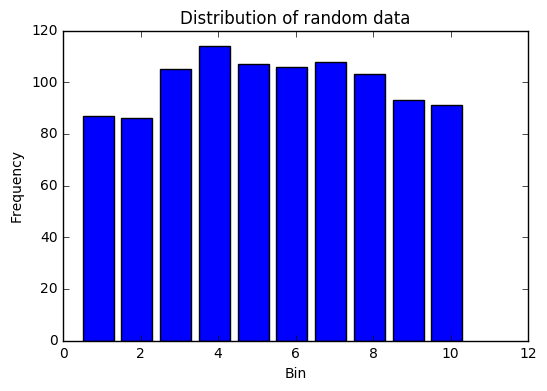

In [6]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np

# First generate some random input data, representing individual candidates.
data = np.random.randint(low=1,high=11,size=1000)

# Just plot the data to see what it looks like.
bin_centres = np.arange(0.5,10.5, 1)
uniq, counts = np.unique(data, return_counts=True)
plt.bar(bin_centres,counts)
plt.ylabel('Frequency')
plt.xlabel('Bin')
plt.title('Distribution of random data')
plt.show()

# In principle there are only 10 unique matches.
# No we can shuffle the data, e.g.
# np.random.shuffle(data)
# But we would rather sort it here, to simulate the ordering variable.
data = np.sort(data)

Now we pass the data through the code...

In [7]:
# First figure out true stats of data:
from scipy.stats import skew
from scipy.stats import kurtosis

print 'Input data properties:'
print 'Data mean: '    , np.mean(data)
print 'Data STDEV: '   , np.std(data)
print 'Data Skew: '    , skew(data)
print 'Data Kurtosis: ', kurtosis(data), '\n'

extracted_features = extract_features(data)

print 'Extracted features:'
print 'Data mean: '    , extracted_features[0]
print 'Data STDEV: '   , extracted_features[1]
print 'Data Skew: '    , extracted_features[2]
print 'Data Kurtosis: ', extracted_features[3], '\n'

Input data properties:
Data mean:  5.528
Data STDEV:  2.76572160566
Data Skew:  -0.00139708130543
Data Kurtosis:  -1.13568816432 

Extracted features:
Data mean:  5.528
Data STDEV:  2.76572160566
Data Skew:  -0.00139708130542
Data Kurtosis:  -1.13568816432 



---


As can be seen above, the code extracts the correct values. An on-line version of the feature extraction code, is provided in the next section describing distributed sift (in the **update_stats()** function).

### Sifting  
<br>
#### Standard Off-line Sift
Standard sift is an off-line matching problem. Given a fixed size set of tuples $C$, of length $n$, the goal is to remove duplicates contained in $C$. This produces a filtered set $C^\prime$. To achieve the filtering some function $f$ is used. It is the case that $f$ will **never** return a set $C^\prime$, such that $|C^\prime| > |C|$. Rather it is **always** the case the $|C^\prime| \leq |C|$, though in reality $|C^{\prime}| \ll |C|$.  
<br>
To perform the filtering, the function $f$ performs a matching operation over each tuple in $C$. An individual tuple is defined as $c_{i} = \lbrace c_{i}^{1}, \ldots , c_{i}^{m}\rbrace$. A tuple is uniquely identifiable in $C$ via the index $i$, and for all $c_{i} \in C$, $|c_{i}| > 0$ (in others words $m > 0$). We note that the set $C$ is not a multi-set, thus it does not contain any *identical* duplicate items. There are however non-exact duplicates. These must be removed with high accuracy, so that the size of the set $C^{\prime}$ is minimised.  
<br>
Sifting determines whether or not two arbitrary tuples are equivalent via a similarity measure $s$. The similarity measure is usually associated with some decision threshold value $t$, applied over one or more variables that make up a tuple. If the similarity value for two distinct tuples is above some threshold, these are considered a match. Otherwise tuples are considered disjoint.  
<br>
Using some basic probability theory, we can describe the goal for the function $f$ more clearly. Suppose $P(c_{i})$ is the prior probability of the tuple $c_{i}$ having a match in $C$. Now suppose $P(\textrm{match} | c_{i})$, is the probability of a match, conditioned on $c_{i}$ (what is the chance of a match, given I've observed $c_{i}$). An optimal matching algorithm will do the following:  
<br>
$$f(c_{i})=\underset{\textrm{label}\in \lbrace match,\neg match\rbrace}{\operatorname{argmax}} P(\textrm{label}|c_{i}),$$  
<br>
which says $f(c_{i})$ chooses the label that maximises the probability $P(\textrm{label}|c_{i})$ (picks the most likely label). A function that does this well, will achieve a very high accuracy level. However matching is not usually done in an explicitly probabilistic way for practical reasons. Generally heuristics over key variables (e.g. DM, period, acceleration etc) are used to constrain the matching via thresholds. Nonetheless, any threshold choice is effectively a probabilistic proxy, chosen to maximise $P(\textrm{label}|c_{i})$.  
<br>
For example, suppose we use a simple similarity measure $s_{1}$. Imagine that it considers $c_{i}$ and $c_{k}$ duplicates, if their DM values are within $t/2$ of one another (assuming $T$ could be used in this way!). For this test, there are underlying probability distributions. There is a distribution describing the probability of an arbitrary DM being considered the same as the DM of $c_{i}$, and the same goes for  $c_{k}$. This is shown below (below the code).

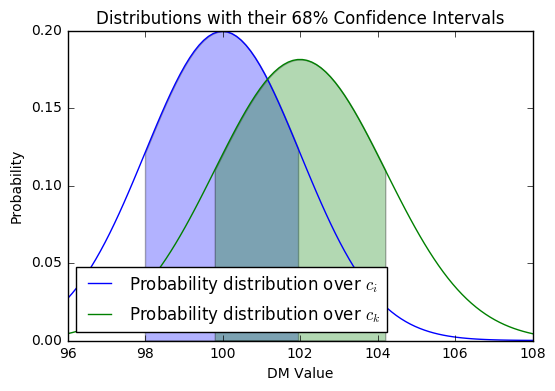

In [8]:
x = np.linspace(96,108, 100)
plt.plot(x,mlab.normpdf(x, 100, 2.0),label='Probability distribution over $c_{i}$')
plt.plot(x,mlab.normpdf(x, 102, 2.2),label='Probability distribution over $c_{k}$')

# Make the shaded regions
section = np.arange(98, 102, 1/20.)
plt.fill_between(section,mlab.normpdf(section, 100, 2.0),facecolor='blue',alpha=0.3, interpolate=True)

section = np.arange(99.8, 104.2, 1/20.)
plt.fill_between(section,mlab.normpdf(section, 102, 2.2),facecolor='green',alpha=0.3, interpolate=True)

plt.xlabel('DM Value')
plt.ylabel('Probability')
plt.title('Distributions with their 68% Confidence Intervals')
plt.legend(loc='lower left')
plt.show()
plt.savefig("test.pdf",bbox_inches='tight')

These distributions can be used in principle, to estimate the probability of a value randomly falling in a predefined range. You can compute the joint probability $P(\textrm{DM in 68\% interval for } c_{i}) \times P(\textrm{DM in 68\% interval for } c_{k})$, and use that to estimate the similarity. You then choose the most likely outcome based on the probability.

#### 'Best' sift
The current 'best' approach does a brute force comparison of each $c_{i}$, to every $c_{k}$ according to $s$. This has a memory complexity of $\mathcal{O}(n)$ given that all $n$ candidates must be stored in memory. Run time is typically $\mathcal{O}(n^{2})$, quadratic complexity. We note that minor adjustments to the brute force approach can yield better runtime performance, e.g. simply by realising that a decreasing number of comparisons only need be done (i.e. there are only so many unique comparison permutations). The total number of possible permutations for a set of length $n$, where $k$ items are compared at a time, is given by:  
<br>
$$\frac{n!}{(n-k)!\cdot k!}$$  
<br>
Thus for the example above we have,  
<br>
$$ \textrm{Permuations} =  \frac{3!}{(3-2)! \cdot 2!}$$  
<br>
$$ = \frac{6}{(1)! \cdot 2}$$  
<br>
$$ = \frac{6}{1 \cdot 2}$$  
<br>
$$ = \frac{6}{2}$$  
<br>
$$ = 3$$  
<br>
Technically speaking this approach is dominated by $\mathcal{O}(n!)$ runtime complexity for all $k$. In practice, for $k=2$, it is dominated by $\mathcal{O}(\frac{1}{2}(n-1)n)$ (rearranged original formula assuming $k=2$). These two orders of complexity are compared below.

/Users/rob/anaconda/lib/python2.7/site-packages/matplotlib/legend.py:325: UserWarning: Unrecognized location "top left". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  six.iterkeys(self.codes))))


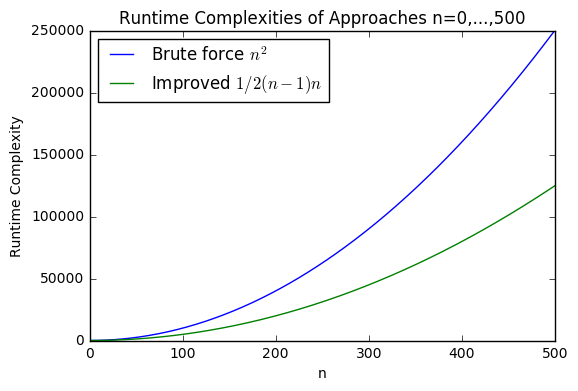

In [9]:
def brute_force(n): return n*n
def improved(n): return 0.5*(n-1)*n

x = np.linspace(0,500, 500)
plt.plot(x,brute_force(x),label='Brute force $n^{2}$')
plt.plot(x,improved(x),label='Improved $1/2 (n-1)n$')
plt.ylabel('Runtime Complexity')
plt.xlabel('n')
plt.title('Runtime Complexities of Approaches n=0,...,500')
plt.legend(loc='top left')
plt.show()

#### Streaming Sift Challenge
The goal of streaming sift (on-line sift) is to match each $c_{i}$, when the the size of $C$ is unbounded (unknown $n$). Ideally streaming sift should i) return only those candidates which cannot be matched, and ii) limits the number of candidates returned for practical reasons to approximately $n_{matches}=1000$. This is difficult to do. The brute force approach becomes invalid, as the memory required to undertake streaming sift is unbounded. How then to compare each $c_{i} \in C$, when given only $C^{\prime\prime} \subset C$ to match against at any one time. The problem needs redefining slightly.  
<br>
We suppose there is a computational system outputting elements from $C$ incrementally, according to some interval $t_{int}$. This interval may vary in size. However it will always be the case that candidates will arrive in a temporally ordered fashion, one at a time (discreet time model). We extend the notation used previously. Now $c_{i}$ is now the candidate arriving at time step $i$, and $c_{1}$ always arrives before $c_{2}$. The set of candidates $C$ can now be easily viewed as a stream containing $c_{1}$ to $c_{n}$.  
<br>
We assume candidates output by the computational system will be ordered according to $c_{i}^{0}$ (the ordering variable). This ordering must be strict, so that $\forall c_{i} \in C$, $c_{i}^{0} \leq c_{i+1}^{0}$. This definition specifies an ascending order, though it would make no difference if there were descending.  
<br>
The stream we are dealing with also exhibits bursty behaviour. The system producing candidates will stop doing so for an intermittent period, before starting again at a later time. Only candidates arriving in the same burst should be considered for matching (analogous to an observation).  To capture this, we modify our streaming model slightly (this modification is fairly unique).   
<br>
The modified goal for streaming sift is to remove duplicates occurring within the same burst $b$, such that for each burst, no more than $n_{matches}=1000$ are returned. We modify the notation $c_{i}$, so that $c_{ib}$ now identifies the burst a candidate belongs to, and to which its ordering applies (with $c_{ib}^{j}$ updated accordingly). To be clear, as the ordering is reset after each burst, $\forall c_{ib}^{0} \in C$, it cannot be assumed that $c_{ib}^{0} \leq c_{i+1b+1}^{0}$ (the batches are not necessarily output in ascending order). Nor can it be assumed that $c_{ib}^{0} \geq c_{i+1b+1}^{0}$ (no descending order either). The number of candidates in a burst is indeterminate, and will fluctuate over time.  
<br>
To complicate matters, there may be more unique candidates in a burst than $n_{matches}$. Only the most promising candidates should be retained. Here 'promise' is indicated by some metric or characteristic (e.g. S/N) represented by $c_{ib}^{1}$ for convenience. As the most promising candidates can appear anywhere in a burst, and as there can be more than $n_{matches}$ such candidates, it is possible to miss out on these if they occur at the end of a burst.  
<br>
This is simply a consequence of choosing candidates too eagerly early on, leaving no room for other promising candidates. This trade-off is difficult to overcome. Especially as it is desirable for streaming sift to immediately flag highly promising candidates for further processing.
<br>
Next we look at two sifting variants that can be used to overcome these challenges.

#### Distributed On-line Sift
Distributed sift operates on one candidate at a time, as opposed to candidate batches. It's assumes an ordering over candidate pulse periods. Using this ordering, candidates can be partitioned by their pulse periods. This ensures that candidates with similar periods (i.e. more likely to be duplicates), can be grouped and processed together. A  frequency counting approach can be used to check for duplicates. The logic underpinning this approach is simple. If a period has been observed many times, it is a possible duplicate. When duplicates are compared via other variables (e.g. DM), frequency counting can be used to accurately find duplicates.  
<br>
The general approach is is presented in the code below. It assumes a stream partitioning that ensures candidates with similar periods (measured in $\mu$s) arrive at the same nodes.

In [10]:
"""
*********************************************************************************

 Node.py

*********************************************************************************
 Description:

 A node object capable of undertaking disributed sift.

*********************************************************************************
 Author: Rob Lyon
 Email : robert.lyon@manchester.ac.uk
 web   : www.scienceguyrob.com
*********************************************************************************
 License:

 Code made available under the GPLv3 (GNU General Public License), that
 allows you to copy, modify and redistribute the code as you see fit
 (http://www.gnu.org/copyleft/gpl.html). Though a mention to the
 original author using the citation above in derivative works, would be
 very much appreciated.
*********************************************************************************
"""

class Node(object):
    """
    Creates a computational node object. A node is used to process
    a portion of a candidate data stream, partitioned according to
    candidate pulse periods.
    
    A node maintains counts of the periods it has observed. It uses
    this information to determine if a new candidate is a possible
    match.
    """
    
    def __init__(self,min_period,max_period,bins=1000001):
        """
        Initialises the node.
        
        Parameters
        ----------
        :param min_period: the minimum period observed at the node.
        :param max_period: the maximum period observed at the node.
        :param bins: the number of frequency counting bins, by default there are 1,000,001
                    bins which gives microsecond counting resolution.
                    
        Returns
        ----------
        :return: N/A
        """
        self.bins = bins
        self.min_period = min_period
        self.max_period = max_period
        
        # Now create the window as a first in, first out (FIFO) queue.
        self.periods = []
        
        if self.bins is not None:
            if self.bins > 0:
                for x in range(0, bins):
                    self.periods.append(0)
            else:
                print 'Bins must be > 0!'
        else:
            print 'Bins must not be None!'
        
        # Variables used to compute stats over the long term.
        self.observed     = 0 # Total examples observed...
        self.overall_sum  = 0
        self.overall_mean = 0
        self.overall_var  = 0
        self.overall_m2   = 0 # Used to compute variance online.
    
    # *********************************************************************************
    
    def isDuplicate(self,x):
        """
        Observes a new example x, and updates the period counts.
        Returns true if the value x is a duplicate, else false.
        
        Parameters
        ----------
        param x: the input candidate.

        Returns
        ----------
        :return: True if x is a duplicate, else False.
        """
        
        # Increment counter
        self.observed +=1
        
        # Update stream stats
        self.update_stats(x)
        
        if self.bins is not None:
            if self.bins > 0:
                
                if x < self.min_period:
                    print 'Cannot sift, value outside period range!'
                elif x > self.max_period:
                    print 'Cannot sift, value outside period range!'
                else:
                    # try to sift
                    
                    period_microseconds = int(round(x * 1000,0))
                    
                    if(self.min_period < 0 or self.max_period > 1.0):
                        index = self.scale(period_microseconds, self.min_period, self.max_period, 0.0, 1000000)
                    else:
                        index = int(period_microseconds)

                    # If this period has been seen before
                    if(self.periods[int(period_microseconds)] > 0):
                        self.periods[int(period_microseconds)] = self.periods[int(period_microseconds)]+1
                        return True
                    else:
                        self.periods[int(period_microseconds)]= self.periods[int(period_microseconds)]+1
                        return False;

        
    # *********************************************************************************

    def scale(self,x, data_min, data_max, floor, ceil):
        """
        Scales a numerical value to the desired range.

        Parameters
        ----------
        :param x : the value to scale
        :param data_min: min the minimum value of the data range for v.
        :param data_max: max the maximum value of the data range for v.
        :param floor: floor the minimum value of the new limit.
        :param ceil: ceil the maximum value of the new limit.

        Returns
        ----------
        :return: A new array with the data scaled to within the range [new_min,new_max].
        """
        
        return ((ceil - floor) * (x - data_min) / (data_max - data_min)) + floor
    
    # *********************************************************************************
    
    def update_stats(self,x):
        """
        Updates the window statistics, uses a flag to
        indicate if the statisitics should be updated
        as a result of an item being removed from the
        window, or added to the window.
        
        Parameters
        ----------
        param x: the input candidate observed.

        Returns
        ----------
        :return: N/A
        """
        
        # There are two possibilities. Either,
        # 1. Update given a new observation.
        # 2. update after an example has left the window.
        # The following if statement captures this.
        
        # If enough examples have been observed to compute the statistics.
        if self.observed > 2:

            # Now for the OVERALL statistics...
            # We compute these using the on-line algorithm for variance below.
            # For more info on the algorithm (and papers) see:
            #
            # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance
            #
            # and look for the 'Online algorithm'.
            self.overall_sum += x
            delta = float(x) - float(self.overall_mean)
            self.overall_mean += float(delta) / float(self.observed)
            self.overall_m2 += delta * (x - self.overall_mean)
            self.overall_var = float(self.overall_m2) / float((self.observed - 1))
                
        else:
            # Too few examples seen to compute all stats, we just update
            # those we can.
            self.overall_sum += x
    
    # *********************************************************************************
    
    def reset(self):
        """
        Resets the window for the next batch of data.
        
        Parameters
        ----------
        N/A

        Returns
        ----------
        :return: N/A
        """
        self.periods = []
        
        if self.bins is not None:
            if self.bins > 0:
                for x in range(0, self.bins):
                    self.periods.append(0)
            else:
                print 'Bins must be > 0!'
        else:
            print 'Bins must not be None!'
        
        # Variables used to compute stats over the long term.
        self.observed = 0
        self.overall_sum = 0
        self.overall_mean = 0
        self.overall_var = 0
        self.overall_m2 = 0
    
    # *********************************************************************************
    
    def debug(self):
        """
        Prints the contents of the window to standard out,
        along with window and stream statistics.
        
        Parameters
        ----------
        N/A

        Returns
        ----------
        :return: N/A
        """
        print "Observed:"     , self.observed
        print "Overall Sum: " , self.overall_sum
        print "Overall Mean: ", self.overall_mean
        print "Overall Var:"  , self.overall_var
    
    # *********************************************************************************
    
    def __iter__(self):
        """
        Returns an interable list containing the node period count.
        
        Parameters
        ----------
        N/A

        Returns
        ----------
        :return: The period count.
        """
        return self.periods

##### Test of Distributed Sift

Here we simply test the approach by generating artificial period data.


Testing the on-line distributed sift method...

Now testing the sift algorithm on a small sample of examples

Node 1 Duplicates:  0 (should be 0 duplicates).
Node 2 Duplicates:  8 (should be 8 duplicates)
Node 3 Duplicates:  1 (should be 1 duplicate)
Now moving on to larger scale test


Creating some randomly sampled period data...


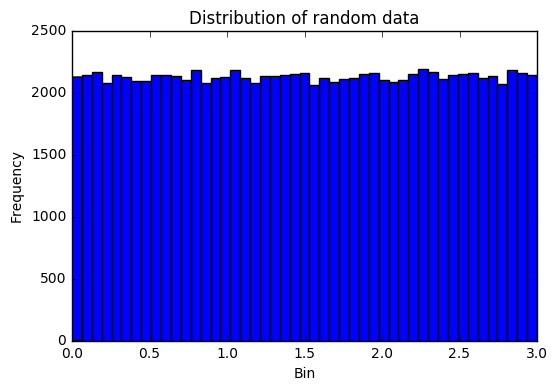


Now sifting  100000  randomly sampled periods.
Node 1 Duplicates:  32260
Node 2 Duplicates:  32289
Node 3 Duplicates:  32448
Total duplicates: 96997
Unique periods: 3003


In [11]:
print 'Testing the on-line distributed sift method...\n'
# Create nodes that will process the data.
n_1 = Node(0,1)
n_2 = Node(1,2)
n_3 = Node(2,3)


# Basic tests of individual nodes. Here we generate some period
# contrived period data, and pass it through the nodes. 

# Create variables to count duplicates at each node.
n_1_duplicates = 0
n_2_duplicates = 0
n_3_duplicates = 0

# Now generate the contrived data
dist_data_1 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # No matches
dist_data_2 = [1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1] # All matches
dist_data_3 = [2.1,2.2,2.3,2.4,2.4,2.5,2.6,2.7,2.8] # One match

print 'Now testing the sift algorithm on a small sample of examples\n'
# Here below we asume a stream partioning, so nodes process data
# for different periods explicitly.

# Periods for node one...
for x in dist_data_1:
    
        duplicate = n_1.isDuplicate(x)
        
        if duplicate:
            n_1_duplicates +=1

# Periods for node two...
for x in dist_data_2:
    
        duplicate = n_2.isDuplicate(x)
        
        if duplicate:
            n_2_duplicates +=1

# Periods for node three
for x in dist_data_3:
        duplicate = n_3.isDuplicate(x)
        
        if duplicate:
            n_3_duplicates +=1
            
print 'Node 1 Duplicates: ', n_1_duplicates , '(should be 0 duplicates).'
print 'Node 2 Duplicates: ', n_2_duplicates , '(should be 8 duplicates)'
print 'Node 3 Duplicates: ', n_3_duplicates , '(should be 1 duplicate)'

# Reset the nodes/counters since we'll now process new data.
n_1.reset()
n_2.reset()
n_3.reset()
n_1_duplicates = 0
n_2_duplicates = 0
n_3_duplicates = 0

print 'Now moving on to larger scale test'
# Generate some data for more realistic test
random_samples = 100000
print '\n\nCreating some randomly sampled period data...'
dist_data = np.random.uniform(low=0.0,high=3.0,size=random_samples)

# Just plot the data to see what it looks like.
plt.hist(dist_data, bins='auto')
plt.ylabel('Frequency')
plt.xlabel('Bin')
plt.title('Distribution of random data')
plt.show()

# Sort the data to simulate the ordering variable.
dist_data = np.sort(dist_data)

# Now process the new random (uniformly sampled) data.
print '\nNow sifting ', random_samples, ' randomly sampled periods.'

# Below we asume a stream partioning, acheived via the use
# of simple if statements.
for x in dist_data:
    
    if x < 1.0:
        duplicate = n_1.isDuplicate(x)
        
        if duplicate:
            n_1_duplicates +=1
    
    elif x < 2.0:
        duplicate = n_2.isDuplicate(x)
        
        if duplicate:
            n_2_duplicates +=1
            
    elif x < 3.0:
        
        duplicate = n_3.isDuplicate(x)
        
        if duplicate:
            n_3_duplicates +=1
            
print 'Node 1 Duplicates: ', n_1_duplicates
print 'Node 2 Duplicates: ', n_2_duplicates
print 'Node 3 Duplicates: ', n_3_duplicates

print 'Total duplicates:' , str(n_1_duplicates + n_2_duplicates + n_3_duplicates)
print 'Unique periods:' , str(random_samples - (n_1_duplicates + n_2_duplicates + n_3_duplicates))

 The results here are as expected. The approach can be modified to consider DM and other variables easily. However we do not include such code here. It is left for future work.

#### Windowed Sift
We have an outline design for a on-line 'windowed' sift algorithm. This algorithm begins the sifting process, by initialising some key variables:  
<br>
1. A pool used to store promising candidates from a burst, which has a maximum size of $n_{matches}$.

2. A sliding window over the stream. This starts at the beginning of the burst. It ends at a location consistent where there is little or no chance of the example of at the start of the window, being related to the example at the end. This notion of likelihood will be captured by some statistical test. Over time the window will move according to the current $c_{i}$ being processed.

3. A number of statistics:

    3.1. a count of the examples observed in the burst so far.
    
    3.2. a count of the examples in the pool.
    
    3.3. a count of the examples in the pool passed on for further processing.
    
    3.4. the current length of the sliding window.
    
    3.5. a count of the probable duplicates found in the burst so far.  
<br>
Following variable initialisation, there are two possible scenarios. In the first, the algorithm begins buffering a small number of candidates to construct the sliding window. The number of examples buffered depends on the metric used to determine the likelihood of similarity (between the example at the start of the window, and that at the end). This approach can waste time populating the buffer, but may lead to better results in the long run. It is also more complicated to implement. For example, once the first 50 examples have been buffered, you then have to go back to $c_{1}$, undertake comparisons, then do the same for $c_{2},\ldots,c_{50}$.  
<br>
The alternative approach is to not wait. Here we simply construct the window on the first example seen. The algorithm then attempts to match the first candidate to those stored in the window. As no other candidates will have been seen at this point, $c_{1}$ will be automatically assigned to the pool as a promising candidate, in absence of additional information.  
<br>
With no buffering, time is saved. However it is possible for this approach to lead to sub-optimal candidates being sent too early for further processing, as so few comparisons have taken place. To prevent this becoming a significant problem, a simple constraint can be applied. Simply ensure that at least $n_{min}$ candidates had been seen, before any are sent onwards.  
<br>
This constraint achieves the same effect as buffering (a wait), though it is easier to implement. It should also be noted that in the stream mining domain more generally, a statistical test would be used to determine the appropriate number of candidates to observe, before allowing candidates to be forwarded on. This is typically controlled by a desired level of user confidence $\delta \in [0,1]$. A $\delta = 0.95$ implies the user wants to be 95% confident, that enough examples have been observed.  
<br>
However the initialisation of the window is done, each subsequent candidate that arrives, will be compared to those in the current sliding window. If there is a match between $c_{i}$ and $c_{i+1}$ in the window, and $c_{i+1}$ has the best $c_{ib}^{1}$, it will be compared to those in the pool. If there is a match in the pool, then the best match will be retained in the pool, and the other discarded. If the candidate is deemed very promising according to some heuristic $h$, then it will be immediately sent for further processing, and the appropriate counts updated. The pool will also be decreased in length by 1, with the sent candidate retained for further burst comparisons. If the pool is full when this occurs, the least promising candidate in the pool has to be discarded to enable the pool to shrink.  
<br>
In principle this approach would appear to be sound. Provided the window is large enough, you could always compare similar candidates to one another. This should enable the fast identification of matches. There are obviously lots of implementation specific details not considered here. Those are not a concern right now, as we think about this as a proof of concept.

##### Stream Windowing Algorithms

There are two possible ways to construct a window. Either incrementally, or in a single go based on a buffer of observed examples. There are actually three general models for this (Wu & Chen, 2006):  
<br>
1. A landmark data model - this considers the data in the stream from the start until 'now'.

2. A sliding window model - this considers the data from 'now', up to a certain point/range in the past.

3. A damped window model - this associates weights with the stream data, and gives higher weights to more recent data.  
<br>
Our window is considered to be a time-based landmark window (see Pramod & Vyas, 2012).  
<br>
There are other general methods. One of the more popular is **ADWIN** (Bifet & Gavaldà, 2007). **ADWIN** maintains a single sliding window $W$ over a data stream. The window is actually made up of sub-windows $W_{1}$ and $W_{2}$ (though more windows can be used!). As data moves through $W$, the respective means and variances of the sub-windows are computed. A statistical equality test is then done on these values, and a probabilistic estimate of similarity obtained. If the respective means and variances of the sub-windows are different, then this is interpreted to mean there has been a significant distributional shift in $W$. Thus the older portion of the window is dropped.  
<br>
Based upon this approach, I've devised a potentially useful strategy. The code below describes this method. It is based on a basic queue, assuming the first in, first out principle (FIFO). It maintains both window and stream statistics, and accepts user parameters. 

##### Prototype 'Windowed' Algorithm

In [12]:
"""
*********************************************************************************

 Window.py

*********************************************************************************
 Description:

 A sifting algorithm that utilises a sliding window.

*********************************************************************************
 Author: Rob Lyon
 Email : robert.lyon@manchester.ac.uk
 web   : www.scienceguyrob.com
*********************************************************************************
 License:

 Code made available under the GPLv3 (GNU General Public License), that
 allows you to copy, modify and redistribute the code as you see fit
 (http://www.gnu.org/copyleft/gpl.html). Though a mention to the
 original author using the citation above in derivative works, would be
 very much appreciated.
*********************************************************************************
"""
from collections import deque

class Window(object):
    """
    Creates the object responsible for managing a sliding window.
    
    The window maintains statistics over its contents. For simplicity
    this window assumes its contents to be simply natural numbers.
    """
    
    def __init__(self,max_size,conf,adapt=False):
        """
        Initialises the window.
        
        Parameters
        ----------
        :param max_size: the maximum allowable size of the window.
        :param conf: the desired level of user confidence for change detection or matching.
        :param adapt: boolean flag, when true causes the window to change size adaptively.
        
        Returns
        ----------
        :return: N/A
        """
        self.default_W_max = max_size
        self.W_max = max_size
        self.delta = conf
        self.length = 0 # Length of the window.
        
        # A flag that when true, will allow the window to adapt, by
        # altering W_max dynamically.
        self.adaptive = adapt
        
        # Now create the window as a first in, first out (FIFO) queue.
        self.contents = deque()
        
        # Variables used to compute stats over the window.
        self.window_sum = 0
        self.window_mean = 0
        self.window_var = 0
        
        # Variables used to compute stats over the long term.
        self.observed = 0 # Total examples observed...
        self.overall_sum = 0
        self.overall_mean = 0
        self.overall_var = 0
        self.overall_m2 = 0 # Used to compute variance online.
    
    # *********************************************************************************
    
    def observe(self,x):
        """
        Observes a new example x, and slides the window accordingly.
        
        Parameters
        ----------
        :param x: the input value observed.

        Returns
        ----------
        :return: N/A
        """
        
        # Increment counter
        self.observed +=1
        
        # If the window is able to grow, then let it.
        if self.canGrow():
            
            # This will append x to the left hand side of the window.
            # For example, if the window contains:
            #
            #  Tail    Head
            #   |       |
            #   v       v
            # [ c , b , a ]
            #
            # then self.window.appendleft(d)
            #
            # would give,
            #
            # [ d , c , b , a ]
            self.contents.appendleft(x)
            self.length +=1
            
            # Now make the window recompute monitoring stats.
            self.update_stats(x,remove=False)
            
        else:
            # The window size has reached it's hard limit.
            # Remove the tail from the window to make room.
            self.removeOldest()
            
            # Add the new item to the window
            self.contents.appendleft(x)
            
            # The call to removeOldest() above decreases
            # the length, so we must increase it here.
            self.length +=1
            
            # Simply make the window recompute monitoring stats.
            self.update_stats(x,remove=False)
        
        # If the window can adapt by choosing its own W_max value,
        # then let it, based on the updated statistics computed after
        # x was observed.
        if self.adaptive:
            self.adapt()
    
    # *********************************************************************************
    
    def removeOldest(self):
        """
        Removes the oldest item in the window, updates
        window statisitics accordingly.
        
        Parameters
        ----------
        N/A

        Returns
        ----------
        :return: N/A
        """
        
        if(self.length > 0):
            # Pop the right most window item, this call removes it.
            oldest = self.contents.pop()
            self.length +=-1 # Decrement fudge...

            # Update the window statistics.
            self.update_stats(oldest,remove=True)
        
    # *********************************************************************************
    
    def update_stats(self,x,remove=False):
        """
        Updates the window statistics, uses a flag to
        indicate if the statisitics should be updated
        as a result of an item being removed from the
        window, or added to the window.
        
        Parameters
        ----------
        :param x: the input value observed.
        :param remove: flag that when true, updates window stats
                       following an observation leaving the window.

        Returns
        ----------
        :return: N/A
        """
        
        # There are two possibilities. Either,
        # 1. Update given a new observation.
        # 2. update after an example has left the window.
        # The following if statement captures this.
        
        # If enough examples have been observed to compute the statistics.
        if self.observed > 2:
            
            if remove:

                # Then the example x is being removed from the window,
                # and we must recompute our window statisitics to reflect
                # that.
                self.window_sum += -x # Decrease sum.
                self.window_mean = float(self.window_sum) / float(self.length) # recompute sample mean 
                
                # Calculate variance - this call may be computationally expensive
                # in the long run, but we can cross that bridge later...
                self.window_var = np.var(map(float, self.contents))
                
                # No need to do overall stats computation, this is done
                # only when adding a new example for the first time.
                
            else:
                # Then x is being added to the window. This means it is being
                # observed for the first time, so overall stats must also be updated.
                self.window_sum += x
                self.window_mean = float(self.window_sum) / float(self.length) # sample mean 
                
                # Calculate variance - this call may be computationally expensive
                # in the long run, but we can cross that bridge later...
                self.window_var = np.var(map(float, self.contents)) # Convert float for Numpy call.
                
                # Now for the OVERALL statistics...
                # We compute these using the on-line algorithm for variance below.
                # For more info on the algorithm (and papers) see:
                #
                # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance
                #
                # and look for the 'Online algorithm'.
                self.overall_sum += x
                delta = float(x) - float(self.overall_mean)
                self.overall_mean += float(delta) / float(self.observed)
                self.overall_m2 += delta * (x - self.overall_mean)
                self.overall_var = float(self.overall_m2) / float((self.observed - 1))
                
        else:
            # Too few examples seen to compute all stats, we just update
            # those we can.
            self.window_sum += x
            self.overall_sum += x
                
    # *********************************************************************************
    
    def canGrow(self):
        """
        Tests if the window is able to grow.
        
        Parameters
        ----------
        N/A

        Returns
        ----------
        :return: True if able to grow, else false.
        """
        if(self.length < self.W_max):
            return True
        else:
            return False
    
    # *********************************************************************************
    
    def adapt(self):
        """
        Causes the window to modify W_max based on the data it has observed.
        
        Parameters
        ----------
        N/A

        Returns
        ----------
        :return: N/A
        """
        if self.hasChanged():
            
            # Do some adaptation.
            
            # Not important now, implement later.
            print 'There has been a change.'
    
    # *********************************************************************************
    
    def hasChanged(self):
        """
        Tests if there has been a statistically significant shift in the window.
        
        Parameters
        ----------
        N/A

        Returns
        ----------
        :return: True if a change has occured, else false.
        """
        # Not important now, implement later.
        #
        # Here is ane example, which uses the Hoeffding bound:
        # error_epsilon = np.sqrt(np.log(1/self.delta)/(2*self.window))
        # 
        #
        return False
    
    # *********************************************************************************
    
    def reset(self):
        """
        Resets the window for the next batch of data.
        
        Parameters
        ----------
        N/A

        Returns
        ----------
        :return: N/A
        """
        self.W_max = self.default_W_max
        self.length = 0
        
        # Now create the window as a first in, first out (FIFO) queue.
        self.contents = deque()
        
        # Variables used to compute stats over the window.
        self.window_sum = 0
        self.window_mean = 0
        self.window_var = 0
        
        # Variables used to compute stats over the long term.
        self.observed = 0
        self.overall_sum = 0
        self.overall_mean = 0
        self.overall_var = 0
        self.overall_m2 = 0
    
    # *********************************************************************************
    
    def debug(self):
        """
        Prints the contents of the window to standard out,
        along with window and stream statistics.
        
        Parameters
        ----------
        N/A

        Returns
        ----------
        :return: N/A
        """
        
        print "Window Sum: ", self.window_sum
        print "Window Mean: ", self.window_mean
        print "Window Var:" , self.window_var
        print "Overall Sum: ", self.overall_sum
        print "Overall Mean: ", self.overall_mean
        print "Overall Var:" , self.overall_var
        print "Window Contents:\n\t",self.contents
    
    # *********************************************************************************
    
    def printWindow(self):
        """
        Prints the contents of the window to standard out.
        
        Parameters
        ----------
        N/A

        Returns
        ----------
        :return: N/A
        """
        
        print self.contents
    
    # *********************************************************************************
    
    def __iter__(self):
        """
        Returns an interable list containing items in the window.
        
        Parameters
        ----------
        N/A

        Returns
        ----------
        :return: The items in the window.
        """
        return self.contents

Now we have are algorithm to test. Next we generate some input data to see what it does.

##### Test Data Generation for Windowed Approach

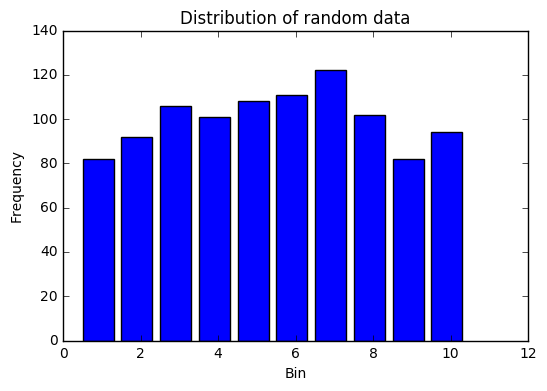

In [13]:
# First generate some random input data, representing individual candidates.
data = np.random.randint(low=1,high=11,size=1000)

# Just plot the data to see what it looks like.
bin_centres = np.arange(0.5,10.5, 1)
uniq, counts = np.unique(data, return_counts=True)
plt.bar(bin_centres,counts)
plt.ylabel('Frequency')
plt.xlabel('Bin')
plt.title('Distribution of random data')
plt.show()

# In principle there are only 10 unique matches.
# No we can shuffle the data, e.g.
# np.random.shuffle(data)
# But we would rather sort it here, to simulate the ordering variable.
data = np.sort(data)

Now we pass the data through the window.

##### Testing of 'Windowed' Approach

In [14]:
print 'Testing Windowed Sift...'
# Now we try to simulate a window over the data.
max_window_size = 10 # The maximum allowable window length.
user_conf = 0.8 # The desired level of user confidence.

win = Window(max_window_size,user_conf)

# First figure out true stats of data:
print 'Input data properties:'
print 'Data sum: ', sum(data)
print 'Data mean: ', np.mean(data)
print 'Data var: ', np.var(data) ,'\n'

for d in data:
    win.observe(d)

print 'As observed by window class:'
win.debug()

Testing Windowed Sift...
Input data properties:
Data sum:  5542
Data mean:  5.542
Data var:  7.550236 

As observed by window class:
Window Sum:  100
Window Mean:  10.0
Window Var: 0.0
Overall Sum:  5542
Overall Mean:  5.54
Overall Var: 7.57797797798
Window Contents:
	deque([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])


As you can see above, the window has done fairly well at estimating the overall mean & variance (using the on-line non-exact algorithm). it has also computed statistics for the current (and last) window specifically. We now try to check the algorithm works as expected more carefully. Below I visualise the movement of examples through the window.

In [15]:
win.reset() # Resets the window's variables.

samples = 20
min_value = 1
max_value = 10
# Now we create a data generator.
for i in range(samples):
    # Create a random number
    win.observe(np.random.randint(low=min_value,high=max_value,size=1)[0])
    win.printWindow()

print "\nSummary Stats:"
win.debug()

deque([7])
deque([3, 7])
deque([8, 3, 7])
deque([8, 8, 3, 7])
deque([6, 8, 8, 3, 7])
deque([1, 6, 8, 8, 3, 7])
deque([4, 1, 6, 8, 8, 3, 7])
deque([4, 4, 1, 6, 8, 8, 3, 7])
deque([3, 4, 4, 1, 6, 8, 8, 3, 7])
deque([3, 3, 4, 4, 1, 6, 8, 8, 3, 7])
deque([3, 3, 3, 4, 4, 1, 6, 8, 8, 3])
deque([5, 3, 3, 3, 4, 4, 1, 6, 8, 8])
deque([6, 5, 3, 3, 3, 4, 4, 1, 6, 8])
deque([3, 6, 5, 3, 3, 3, 4, 4, 1, 6])
deque([4, 3, 6, 5, 3, 3, 3, 4, 4, 1])
deque([5, 4, 3, 6, 5, 3, 3, 3, 4, 4])
deque([9, 5, 4, 3, 6, 5, 3, 3, 3, 4])
deque([6, 9, 5, 4, 3, 6, 5, 3, 3, 3])
deque([1, 6, 9, 5, 4, 3, 6, 5, 3, 3])
deque([7, 1, 6, 9, 5, 4, 3, 6, 5, 3])

Summary Stats:
Window Sum:  49
Window Mean:  4.9
Window Var: 4.69
Overall Sum:  96
Overall Mean:  4.3
Overall Var: 6.95789473684
Window Contents:
	deque([7, 1, 6, 9, 5, 4, 3, 6, 5, 3])


Based on the above, it would appear that examples are moving correctly through the window. Using this basic approach, we can start to do simple matching, by comparing against the window.

In [16]:
win.reset() # Resets the window's variables.

# Just pass in 10 samples for simplicity.
samples = 10
min_value = 1
max_value = 10

matches = []
match_count = 0

# Again we create a data generator as before.
for i in range(samples):
    
    # Create and observe a random number
    next_int = np.random.randint(low=min_value,high=max_value,size=1)[0]
    win.observe(next_int)
    
    # Here we basically say that if the new value is equal
    # to any of the other values in the window, then its a match,
    # and it should be ignored (well I add it to a match list
    # for clarity!).
    occurances = 0
    
    # Iterate over examples in window. There are more efficient
    # ways to do this then pure iteration, e.g. tree search or hashing
    # data structures.
    for d in win.contents:
        
        if d == next_int:
            
            occurances+=1
    
    # If a value occurs more than once in the window,
    # it must be a match.
    if occurances > 1:
        
        matches.append(next_int)
        match_count+=1
            
            
print "\nSummary Stats:"
win.debug()

print "\nMatch count: ", match_count
print matches


Summary Stats:
Window Sum:  62
Window Mean:  6.2
Window Var: 6.16
Overall Sum:  62
Overall Mean:  4.5
Overall Var: 10.9444444444
Window Contents:
	deque([8, 4, 9, 4, 3, 3, 5, 9, 9, 8])

Match count:  5
[9, 3, 9, 4, 8]


You can see above its found the matches in the window of the first 10 examples, which is great.

##### Combined Approach

It would be fairly trivial to combine the distributed and windowed approaches. We leave this to future work.

---



# References

*CSIRO, "ANTF Pulsar Catalogue", 2012*, on-line, [http://www.atnf.csiro.au/people/pulsar/psrcat/](http://www.atnf.csiro.au/people/pulsar/psrcat/), accessed 28/04/2016

*Bifet & Gavaldà, "Learning from Time-Changing Data with Adaptive Windowing", Proceedings of the SIAM International Conference on Data Mining, 2007* ([paper link](http://dx.doi.org/10.1137/1.9781611972771.42)).

*Lyon, Stappers, Cooper, Brooke, Knowles "Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach", MNRAS, 459 (1):1104-1123, 2016* ([paper link](https://dx.doi.org/10.1093/mnras/stw656)).

*Lyon & Stappers, "Prototype Pulsar Search Pipeline for High Volume Data Streams", Arxiv, 2017* ([paper link](http://dx.doi.org/)).

*Pramod & Vyas, "Data Stream Mining: A Review on Windowing Approach", Global Journal of Computer Science and Technology
Software & Data Engineering, vol. 1, issue 2, 2012*  ([paper link](http://computerresearch.org/index.php/computer/article/view/553)).

*Wu & Chen, "Maintaining Moving Sums over Data Streams", Advanced Data Mining Application, vol. 4093 of LNCS, pp.1077-1084, 2006* ([paper link](https://dx.doi.org/10.1007/11811305_117)).



# Appendix

## Unit Tests

These unit tests should be executed outside of Jupyter notebooks. The supporting files also used during unit testing are also inlcuded below.

### TestPSRCATEntry



`"""
**************************************************************************
 TestPSRCATEntry.py
**************************************************************************
 Description:
 Tests the class that represents individual ATNF catalog entries.
**************************************************************************
 Author: Rob Lyon
 Email : robert.lyon@postgrad.manchester.ac.uk
 web   : www.scienceguyrob.com
**************************************************************************
 Required Command Line Arguments:
 N/A
**************************************************************************
 Optional Command Line Arguments:
 N/A
**************************************************************************
 License:
 Code made available under the GPLv3 (GNU General Public License), that
 allows you to copy, modify and redistribute the code as you see fit
 (http://www.gnu.org/copyleft/gpl.html). Though a mention to the
 original author using the citation above in derivative works, would be
 very much appreciated.
**************************************************************************
"""

import os
import unittest

# For common operations.
from main.src.data.psrcat.PSRCATEntry import PSRCATEntry

# ******************************
# CLASS DEFINITION
# ******************************

class TestPSRCATEntry(unittest.TestCase):
    """
    Tests the class that represents individual ATNF catalog entries.
    """

    # Points to the resource directory containing test files.
    data_root = os.path.abspath('../..') + '/resources/TEST'

    # ******************************
    #
    # TESTS
    #
    # ******************************

    def test_entry(self):
        """Tests the creation of a PSRCAT entry object, and the methods used to modify it."""

        name = 'FAKE_PULSAR'
        entry = PSRCATEntry(name)

        # Here are some fake lines that will be fed to the entry...
        # RAJ      00:06:04.8               2    cn95
        # DECJ     +18:34:59                4    cn95
        # P0       0.69374767047            14   cn95
        # P1       2.097E-15                12   cn95
        # PEPOCH   49079.5                       cn95
        # DM       12.0                     6    cn95
        entry.process_atnf_formatted_line('RAJ      00:06:04.8               2    cn95')
        self.assertEqual(entry.get_parameter(entry.KEY_RAJ), '00:06:04.8')
        entry.process_atnf_formatted_line('DECJ     +18:34:59                4    cn95')
        self.assertEqual(entry.get_parameter(entry.KEY_DECJ), '+18:34:59')
        entry.process_atnf_formatted_line('P0       0.69374767047            14   cn95')
        self.assertEqual(float(entry.get_parameter(entry.KEY_P0)), 0.69374767047)
        entry.process_atnf_formatted_line('DM       12.0                     6    cn95')
        self.assertEqual(float(entry.get_parameter(entry.KEY_DM)), 12.0)

        # Now check error correction when only part of RA or DEC provided.
        entry.process_atnf_formatted_line('RAJ      00:00               2    cn95')
        self.assertEqual(entry.get_parameter(entry.KEY_RAJ), '00:00:00')
        entry.process_atnf_formatted_line('DECJ     +18:00                4    cn95')
        self.assertEqual(entry.get_parameter(entry.KEY_DECJ), '+18:00:00')
        entry.process_atnf_formatted_line('RAJ      00               2    cn95')
        self.assertEqual(entry.get_parameter(entry.KEY_RAJ), '00:00:00')
        entry.process_atnf_formatted_line('DECJ     +18                4    cn95')
        self.assertEqual(entry.get_parameter(entry.KEY_DECJ), '+18:00:00')

        # Now check period and frequency conversions
        entry.process_atnf_formatted_line('P0       0.69374767047            14   cn95')
        self.assertAlmostEqual(float(entry.get_parameter(entry.KEY_F0)), float(1.4414462816), places=9)

        # Now clear frequency...
        entry.process_atnf_formatted_line('P0       0.0            14   cn95')
        entry.process_atnf_formatted_line('F0       1.4414462816            14   cn95')
        self.assertAlmostEqual(float(entry.get_parameter(entry.KEY_P0)), 0.69374767047,places=9)

    # ****************************************************************************************************

    # ******************************
    #
    # Test Setup & Teardown
    #
    # ******************************

    # preparing to test
    def setUp(self):
        """ Setting up for the test """

    # ****************************************************************************************************

    # ending the test
    def tearDown(self):
        """Cleaning up after the test"""

    # ****************************************************************************************************

    if __name__ == "__main__":
        unittest.main()`


### TestPSRCATParser

`"""
**************************************************************************

 TestPSRCATParser.py

**************************************************************************
 Description:

 Tests the code that parses an ATNF pulsar catalog database file.

**************************************************************************
 Author: Rob Lyon
 Email : robert.lyon@manchester.ac.uk
 web   : www.scienceguyrob.com

**************************************************************************
 Required Command Line Arguments:

 N/A

**************************************************************************
 Optional Command Line Arguments:

 N/A

**************************************************************************
 License:

 Code made available under the GPLv3 (GNU General Public License), that
 allows you to copy, modify and redistribute the code as you see fit
 (http://www.gnu.org/copyleft/gpl.html). Though a mention to the
 original author using the citation above in derivative works, would be
 very much appreciated.

**************************************************************************
"""

import os
import unittest

# For common operations.
from main.src.data.psrcat.PSRCATParser import PSRCATParser


# ******************************
#
# CLASS DEFINITION
#
# ******************************

class TestPSRCATParser(unittest.TestCase):
    """
    Tests the code that parses an ATNF pulsar catalog database file.
    """

    # Points to the resource directory containing test files.
    data_root = os.path.abspath('../..') + '/resources/TEST'

    # ******************************
    #
    # TESTS
    #
    # ******************************

    def test_parse_as_list(self):
        """
        Tests the parsing of an ATNF pulsar catalog database file.
        :return:
        """

        test_catalog_path = self.data_root + '/TEST_PSRCAT/psrcat_10_real_entries.db'

        entries = PSRCATParser.parse_as_list(test_catalog_path)

        # Check some entries are returned, and not just null.
        self.assertIsNotNone(entries)

        # Check the correct number of entries are returned.
        self.assertEquals(len(entries), 10)

        # Check first entry is as expected.
        self.assertEquals(entries[0].get_parameter('RAJ'), '00:06:04.8')
        self.assertEquals(entries[0].get_parameter('DECJ'), '+18:34:59')
        self.assertEquals(entries[0].get_parameter('P0'), '0.69374767047')
        # Special case test for inferred value
        self.assertAlmostEqual(float(entries[0].get_parameter('F0')), float(1.4414462816), places=9)
        self.assertEquals(entries[0].get_parameter('DM'), '12.0')

        # Check last entry is as expected.
        self.assertEquals(entries[9].get_parameter('RAJ'), '00:24:06.7014')
        self.assertEquals(entries[9].get_parameter('DECJ'), '-72:04:06.795')
        self.assertEquals(entries[9].get_parameter('F0'), '311.49341784442')
        # Special case test for inferred value
        self.assertAlmostEqual(float(entries[9].get_parameter('P0')), float(0.0032103407093484), places=9)
        self.assertEquals(entries[9].get_parameter('DM'), '24.36')

    # ****************************************************************************************************

    def test_sort_var(self):
        """
        Tests the angular separation sorting variable.
        :return:
        """

        test_catalog_path = self.data_root + '/TEST_PSRCAT/psrcat_sort_test.db'

        entries = PSRCATParser.parse_as_list(test_catalog_path)

        # Check some entries are returned, and not just null.
        self.assertIsNotNone(entries)

        # Check the correct number of entries are returned.
        self.assertEquals(len(entries), 3)

        # Check first entry is as expected.
        self.assertAlmostEqual(entries[0].getRefSep(), 0.0, places=1)
        self.assertAlmostEqual(entries[1].getRefSep(), 2.5, places=1)
        self.assertAlmostEqual(entries[2].getRefSep(), 148.52505, places=5)


    # ****************************************************************************************************

    # ******************************
    #
    # Test Setup & Teardown
    #
    # ******************************

    # preparing to test
    def setUp(self):
        """ Setting up for the test """

    # ****************************************************************************************************

    # ending the test
    def tearDown(self):
        """Cleaning up after the test"""

    # ****************************************************************************************************

    if __name__ == "__main__":
        unittest.main()`


### TestSuiteRunner

`"""
**************************************************************************
                                                                    
 TestSuite.py
                                                                    
**************************************************************************
 Description:                                                       
                                                                    
 Suite that executes all tests for the CandidateStreamer application.

**************************************************************************
 Author: Rob Lyon                                                   
 Email : robert.lyon@manchester.ac.uk                      
 web   : www.scienceguyrob.com

**************************************************************************
 Required Command Line Arguments:                                   
                                                                    
 N/A
                                                                    
**************************************************************************
 Optional Command Line Arguments:                                   
                                                                    
 N/A

**************************************************************************
 License:                                                           
                                                                    
 Code made available under the GPLv3 (GNU General Public License), that 
 allows you to copy, modify and redistribute the code as you see fit
 (http://www.gnu.org/copyleft/gpl.html). Though a mention to the    
 original author using the citation above in derivative works, would be 
 very much appreciated.

**************************************************************************
"""

# Used for logging purposes, please don't delete.
import logging
import sys

# Unit testing modules
from unittest import TestLoader, TextTestRunner, TestSuite

# ******************************
#
# CLASS DEFINITION
#
# ******************************

class TestSuiteRunner(TestSuite):
    """                
    Executes unit tests on all scripts in the project.
    """

    def __init__(self):
        """
        Default constructor for the base class.

        Parameters
        ----------

        Returns
        ----------

        Examples
        --------
        >>>

        :return: N/A
        """

        # Create a logger object.
        super(TestSuiteRunner, self).__init__()
        self.logger = logging.getLogger('CandStreamer')

        # create a file handler
        handler = logging.FileHandler('StreamerTest.log')

        # Set the logging level.
        self.logger.setLevel(logging.INFO)
        handler.setLevel(logging.INFO)

        # Create the logging format
        formatter = logging.Formatter('%(levelname)s,%(asctime)s,%(message)s', datefmt='%H:%M:%S')

        # Configure the logging handler with the desired output format
        handler.setFormatter(formatter)

        # Setup the log file writer
        ch = logging.StreamHandler(sys.stdout)
        ch.setFormatter(formatter)

        # Add the handlers to the logger
        self.logger.addHandler(handler)
        self.logger.addHandler(ch)

    # ******************************
    #
    # MAIN METHOD AND ENTRY POINT.
    #
    # ******************************

    def main(self):
        """
        Main entry point for the Application.

        Parameters
        ----------

        Returns
        ----------

        Examples
        --------
        >>>
        """

        self.run_tests()

    # ****************************************************************************************************

    def run_tests(self):
        """
        Runs the tests in the test suite.

        Parameters
        ----------

        Returns
        ----------

        Examples
        --------
        >>>

        :return: N/A
        """

        self.logger.info('Running Unit Tests')

        loader = TestLoader()
        suite = TestSuite((
            loader.loadTestsFromTestCase(TestPSRCATEntry),
            loader.loadTestsFromTestCase(TestPSRCATParser)
        ))

        runner = TextTestRunner(verbosity=3)
        runner.run(suite)

        # ****************************************************************************************************


if __name__ == '__main__':
    TestSuiteRunner().main()`


### Supporting files

#### psrcat_10_real_entries.db

This file contains 10 real PSRCAT (version 1.54) entries, with some minor details removed. These were removed so iPython could parse the content as NBConvert strings (i.e. I had to remove underscore symbols).

`PSRJ     J0006+1834                   cnt96       
RAJ      00:06:04.8               2    cn95        
DECJ     +18:34:59                4    cn95        
P0       0.69374767047            14   cn95        
P1       2.097E-15                12   cn95        
PEPOCH   49079.5                       cn95        
DM       12.0                     6    cn95                       
SURVEY   ar4
@----------------------------------------------
PSRJ     J0007+7303                    aaa+09c     
RAJ      00:07:01.7               2    awd+12      
DECJ     +73:03:07.4              8    awd+12      
F0       3.165827392              3    awd+12      
F1       -3.6120E-12              5    awd+12      
F2       4.1E-23                  7    awd+12      
F3       5.4E-30                  9    awd+12      
PEPOCH   54952                         awd+12      
NGLT     1                                          
TYPE     NRAD                                      
SURVEY   FermiBlind
@----------------------------------------------
PSRB     B0011+47                      dth78       
PSRJ     J0014+4746                                
RAJ      00:14:17.75              4    hlk+04      
DECJ     47:46:33.4               3    hlk+04           
F0       0.805997239145           7    hlk+04        
PEPOCH   49664.00                      hlk+04      
DM       30.85                    7    hlk+04          
SURVEY   gb1,gb2,gb3
@----------------------------------------------
PSRJ     J0023+0923                    hrm+11      
RAJ      00:23:16.87910           3    mnf+15      
DECJ     +09:23:23.871            1    mnf+15          
PX       0.4                      3    mnf+15      
P0       0.00305                       hrm+11      
DM       14.3                          hrm+11      
SURVEY   FermiAssoc
@----------------------------------------------
PSRB     B0021-72C                     mld+90      
PSRJ     J0024-7204C                               
RAJ      00:23:50.35311           9    fck+03      
DECJ     -72:04:31.4926           4    fck+03        
F0       173.708218966053         5    fck+03      
F1       1.5042E-15               2    fck+03          
DM       24.599                   2    fkl+01      
SURVEY   pksgc
@----------------------------------------------
PSRB     B0021-72D                     mlr+91      
PSRJ     J0024-7204D                               
RAJ      00:24:13.87934           7    fck+03      
DECJ     -72:04:43.8405           3    fck+03        
F0       186.651669856838         6    fck+03      
F1       1.195E-16                2    fck+03       
DM       24.729                   2    fkl+01      
SURVEY   pksgc
@----------------------------------------------
PSRB     B0021-72E                     mlr+91      
PSRJ     J0024-7204E                               
RAJ      00:24:11.1036            1    fck+03      
DECJ     -72:05:20.1377           4    fck+03          
F0       282.77910703517          1    fck+03      
F1       -7.8772E-15              5    fck+03      
DM       24.230                   2    fkl+01      
SURVEY   pksgc
@----------------------------------------------
PSRB     B0021-72F                     mlr+91      
PSRJ     J0024-7204F                               
RAJ      00:24:03.8539            1    fck+03      
DECJ     -72:04:42.8065           5    fck+03      
F0       381.15866365655          2    fck+03      
F1       -9.3707E-15              5    fck+03      
DM       24.379                   5    fkl+01      
SURVEY   pksgc
@----------------------------------------------
PSRB     B0021-72G                     rlm+95      
PSRJ     J0024-7204G                               
RAJ      00:24:07.9587            3    fck+03      
DECJ     -72:04:39.6911           7    fck+03           
F0       247.50152509652          2    fck+03      
F1       2.582E-15                1    fck+03           
DM       24.441                   5    fkl+01      
SURVEY   pksgc
@----------------------------------------------
PSRB     B0021-72H                     mlr+91      
PSRJ     J0024-7204H                               
RAJ      00:24:06.7014            3    fck+03      
DECJ     -72:04:06.795            1    fck+03          
F0       311.49341784442          4    fck+03            
DM       24.36                    3    fkl+01      
SURVEY   pksgc
@----------------------------------------------`


### psrcat_sort_test.db

This file contains 3 fake PSRCAT entries.

`PSRJ     J0001+0001               cnt96
RAJ      00:00:00.0            2   cn95
DECJ     +00:00:00             4   cn95
P0       0.69374767047         14  cn95
DM       12.0                  6   cn95
@-------------------------------------------
PSRJ     J0002+0002                aaa+09c
RAJ      00:10:00              2   awd+12
DECJ     +00:00:00             8   awd+12
DM       10.0                  2   AWD+12
F0       3.165827392           3   awd+12
@-------------------------------------------
PSRJ     J0003+0003                dth78
RAJ      10:00:00              4   hlk+04
DECJ     10:00:00              3   hlk+04
F0       0.805997239145        7   hlk+04
DM       30.85                 7   hlk+04
@-------------------------------------------`
